# Проект 5.<br />Модель кредитного скоринга<br />на основе логистической регресии

## Импорт библиотек и настройки

In [1]:
import re

def install_package(package_name):
    installation_results = !pip install $package_name

    already_installed = False
    already_installed_regex = re.compile(f"already satisfied.*{package_name}")
    successfully_installed = False
    successfully_installed_regex = re.compile(f"[s|S]uccessfully installed.*{package_name}")

    for installation_result in installation_results[::-1]:
        if not already_installed:
            already_installed = already_installed_regex.search(installation_result) != None
        if not successfully_installed:
            successfully_installed = successfully_installed_regex.search(installation_result) != None

    if already_installed:
        print(f"The package \"{package_name}\" is already installed.")
    if successfully_installed:
        print(f"The package \"{package_name}\" is successfully installed.")
    if (not already_installed) and (not successfully_installed):
        installation_details = "\n".join(installation_results)
        print(f"""Looks like the package \"{package_name}\" is not installed correctly.
Please see the installation details:\n{installation_details}""")

In [2]:
install_package("category_encoders")
install_package("imblearn")
# install_package("pprint")

The package "category_encoders" is already installed.
The package "imblearn" is already installed.


In [3]:
# ====================
import locale
import collections as clns
import io
import pprint
# ====================

from pandas import Series
import pandas as pd
import numpy as np

# ====================

import matplotlib.pyplot as plt
import seaborn as sns

# ====================

from category_encoders import OrdinalEncoder

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [4]:
# На всякий случай для дат в частности ставим наиболее "стандартную" локаль
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Настройка matplotlib для IPython
%matplotlib inline

# Отображение максмально возможного количества колонок из DataFrame в Jupyter Notebook
pd.set_option('display.max_columns', None)

### Повторная генерация отчётов в `pandas_profiling`

In [5]:
generate_pandas_profiling_report_settings = {
    "preliminary": False,
    "without_dummies": False,
    "with_dummies": False
}

## Загрузка данных для обучения и тестирования модели,<br />преобразование данных и<br />их первичная обработка

In [6]:
train_data = pd.read_csv("../00-data/kaggle/train.csv")
print(f"Train dataset shape: {train_data.shape[0]} rows \u00d7 {train_data.shape[1]} columns")
train_data.sample(5)

Train dataset shape: 73799 rows × 19 columns


client_id   app_date education sex  age car car_type  decline_app_cnt  \
11514      86988  03APR2014       SCH   M   27   N        N                1   
17354      96019  12APR2014       GRD   F   27   N        N                0   
22517      92975  09APR2014       SCH   F   33   N        N                0   
63937      32827  09FEB2014       GRD   F   46   N        N                1   
53102      23558  30JAN2014       SCH   F   51   N        N                1   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
11514          0  -1.419106                3             80             2   
17354          0  -2.242628                2             60             2   
22517          0  -1.959107                0             80             2   
63937          0  -2.091301                0             70             1   
53102          0  -1.523069                3             70             1   

       work_address  income  sna  first_time foreign_passport  default  
11514             3   30000    2           3                N        0  
17354             3   30000    1           4                N        0  
22517             3   25000    1           4                Y        0  
63937             2   35000    2           2                Y        0  
53102             2   45000    2           3                N        0

In [7]:
test_data = pd.read_csv("../00-data/kaggle/test.csv")
print(f"Test dataset shape: {test_data.shape[0]} rows \u00d7 {test_data.shape[1]} columns")
test_data.sample(5)

Test dataset shape: 36349 rows × 18 columns


client_id   app_date education sex  age car car_type  decline_app_cnt  \
35036      89906  06APR2014       UGR   M   26   N        N                0   
17342      74864  22MAR2014       GRD   F   36   Y        N                0   
6843       22769  29JAN2014       SCH   F   23   Y        N                2   
22396      32263  08FEB2014       GRD   M   36   Y        Y                0   
18730      40965  17FEB2014       GRD   F   24   N        N                1   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
35036          0  -2.162780                2             70             2   
17342          1  -2.387630                6             50             1   
6843           0  -2.315224                0             80             2   
22396          0  -0.899201                1             80             2   
18730          0  -1.391303                1             70             2   

       work_address  income  sna  first_time foreign_passport  
35036             3   45000    1           3                Y  
17342             2   40000    1           3                N  
6843              3   25000    4           2                N  
22396             3   45000    4           1                N  
18730             3   40000    1           3                N

### Объединение тренировочного и тестового датасетов для единого преобразования признаков.
Объединение необходимо для одинакового преобразования всех признаков (переменных).
При этом видно, что в тестовом датасете нет целевой переменной `default`.
Её придётся добавить вручную и приравнять какому-либо заведомо неверному значению,
чтобы ещё более однозначно отличать такие записи от тренировочных.
Но в качестве признака отличия введём, как обычно, специальную колонку `sample`.

In [8]:
test_data["default"] = -1
test_data["sample"] = 0

train_data["sample"] = 1

raw_data = pd.concat([train_data, test_data], ignore_index=True)

In [9]:
raw_data.head(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  sample  
0             2   18000    4           1                N        0       1  
1             3   19000    4           1                N        0       1  
2             2   30000    1           4                Y        0       1  
3             3   10000    1           3                N        0       1  
4             3   30000    1           4                Y        0       1

In [10]:
raw_data.tail(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
110143      83775  31MAR2014       SCH   F   37   N        N                1   
110144     106254  25APR2014       GRD   F   64   Y        Y                0   
110145      81852  30MAR2014       GRD   M   31   N        N                2   
110146       1971  07JAN2014       UGR   F   27   N        N                1   
110147      69044  17MAR2014       SCH   M   38   N        N                0   

        good_work  score_bki  bki_request_cnt  region_rating  home_address  \
110143          0  -1.744976                3             50             2   
110144          0  -2.293781                3             60             1   
110145          0  -0.940752                1             50             1   
110146          0  -1.242392                2             80             2   
110147          0  -1.507549                2             50             1   

        work_address  income  sna  first_time foreign_passport  default  \
110143             3   15000    4           1                N       -1   
110144             2  200000    1           4                N       -1   
110145             2   60000    4           2                N       -1   
110146             3   30000    1           1                N       -1   
110147             2   15000    4           2                N       -1   

        sample  
110143       0  
110144       0  
110145       0  
110146       0  
110147       0

In [11]:
print(f"General raw dataset shape: {raw_data.shape[0]} rows \u00d7 {raw_data.shape[1]} columns")

General raw dataset shape: 110148 rows × 20 columns


### Первичное описание сырых данных

In [12]:
def print_gaps_of_column(data: pd.DataFrame, column_name: str, data_description: str):
    """Calculates gaps and print the gaps info for
    a given columns based on isna() function.
    """
    number_records = data.shape[0]
    gaps_column = data[column_name].isna().sum()
    print(f"Records number in \"{data_description}\": {number_records}.")
    print(f"Gaps in the column \"{column_name}\" in \"{data_description}\": {gaps_column}.")
    print(f"Gaps portion of the column \"{column_name}\" in \"{data_description}\": {(100 * (gaps_column / number_records)):.3f} %")

#### Тренировочные данные

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [14]:
train_data.describe()

client_id           age  decline_app_cnt     good_work  \
count   73799.000000  73799.000000     73799.000000  73799.000000   
mean    55137.965094     39.280641         0.275749      0.164894   
std     31841.921168     11.520378         0.804272      0.371087   
min         1.000000     21.000000         0.000000      0.000000   
25%     27440.500000     30.000000         0.000000      0.000000   
50%     55274.000000     37.000000         0.000000      0.000000   
75%     82758.500000     48.000000         0.000000      0.000000   
max    110147.000000     72.000000        33.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  73799.000000     73799.000000   73799.000000  73799.000000   
mean      -1.904724         2.000339      56.725701      1.575509   
std        0.498231         2.252073      13.055717      0.527631   
min       -3.624586         0.000000      20.000000      1.000000   
25%       -2.259534         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.569831         3.000000      60.000000      2.000000   
max        0.199773        53.000000      80.000000      3.000000   

       work_address          income           sna    first_time       default  \
count  73799.000000    73799.000000  73799.000000  73799.000000  73799.000000   
mean       2.496280    41099.775417      1.733330      2.765458      0.126994   
std        0.689818    46166.322400      1.123622      1.009463      0.332968   
min        1.000000     1000.000000      1.000000      1.000000      0.000000   
25%        2.000000    20000.000000      1.000000      2.000000      0.000000   
50%        3.000000    30000.000000      1.000000      3.000000      0.000000   
75%        3.000000    48000.000000      2.000000      4.000000      0.000000   
max        3.000000  1000000.000000      4.000000      4.000000      1.000000   

        sample  
count  73799.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

##### Пропуски

In [15]:
train_data.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [16]:
print_gaps_of_column(train_data, "education", "train_data")

Records number in "train_data": 73799.
Gaps in the column "education" in "train_data": 307.
Gaps portion of the column "education" in "train_data": 0.416 %


#### Профайлинг тренировочных данных с использованием `pandas_profiling`

In [17]:
import pandas_profiling as pdp
from IPython.core.display import display, HTML

def generate_pandas_profiling_report(
    data: pd.DataFrame,
    report_type: str, report_name: str, report_file: str):
    report_profile = None
    if generate_pandas_profiling_report_settings[report_type]:
        report_profile = pdp.ProfileReport(data, title=report_name)
        report_profile.to_file(report_file)
        report_iframe = report_profile.to_notebook_iframe()
        display(report_iframe)

    return report_profile

In [18]:
report_preliminary = generate_pandas_profiling_report(
    raw_data[raw_data["sample"] == 1], "preliminary",
    "Sample (Train Data) Credit Scoring Data Profiling Preliminary Report",
    "Credit-Scoring-train_data-preliminary.html"
)

#### Тестовые данные

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [20]:
test_data.describe()

client_id           age  decline_app_cnt     good_work  \
count   36349.000000  36349.000000     36349.000000  36349.000000   
mean    54945.647473     39.186002         0.268040      0.166772   
std     31706.052195     11.513258         0.788478      0.372777   
min         4.000000     21.000000         0.000000      0.000000   
25%     27744.000000     30.000000         0.000000      0.000000   
50%     54657.000000     37.000000         0.000000      0.000000   
75%     82322.000000     48.000000         0.000000      0.000000   
max    110148.000000     71.000000        30.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  36349.000000     36349.000000   36349.000000  36349.000000   
mean      -1.904152         2.014471      56.802938      1.573798   
std        0.501764         2.296789      13.086646      0.527428   
min       -3.574197         0.000000      20.000000      1.000000   
25%       -2.261909         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.563957         3.000000      60.000000      2.000000   
max        0.188820        47.000000      80.000000      3.000000   

       work_address          income           sna    first_time  default  \
count  36349.000000    36349.000000  36349.000000  36349.000000  36349.0   
mean       2.501087    40835.755729      1.728053      2.765798     -1.0   
std        0.683227    43802.180951      1.120686      1.011560      0.0   
min        1.000000     1000.000000      1.000000      1.000000     -1.0   
25%        2.000000    20000.000000      1.000000      2.000000     -1.0   
50%        3.000000    30000.000000      1.000000      3.000000     -1.0   
75%        3.000000    48000.000000      2.000000      4.000000     -1.0   
max        3.000000  1000000.000000      4.000000      4.000000     -1.0   

        sample  
count  36349.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

#### Пропуски

In [21]:
test_data.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [22]:
print_gaps_of_column(test_data, "education", "test_data")

Records number in "test_data": 36349.
Gaps in the column "education" in "test_data": 171.
Gaps portion of the column "education" in "test_data": 0.470 %


#### Первичные выводы о данных

В обучающей и тестовой выборках по крайней мере средние значения числовых переменных не сильно различаются.<br />
Минимальные и максимальные значения в тестовой выборке в основном укладываются в интервалы из обучающей.

В обучающей и тестовой выборках реальные пропуски содержатся только в колонке `education`.<br />
Процент пропусков в обоих выборках невелик, но они будут замененены отдельной категорией `NULL`<br />
вместо удаления.

> Records number in "train_data": 73799.<br />
> Gaps in the column "education" in "train_data": 307.<br />
> Gaps portion of the column "education" in "train_data": 0.416 %

> Records number in "test_data": 36349.<br />
> Gaps in the column "education" in "test_data": 171.<br />
> Gaps portion of the column "education" in "test_data": 0.470 %

### Анализ целевой переменной `default`

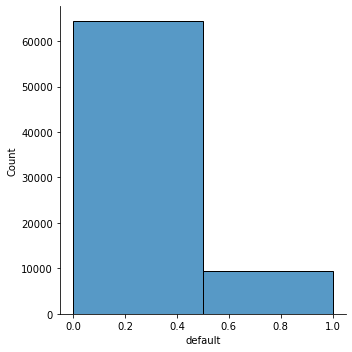

In [23]:
sns.displot(train_data["default"], bins=2)

#### Отношения классов и их веса

In [24]:
target_variable = train_data["default"]
sample_size = target_variable.size
n_classes = 2

class_positive = target_variable[target_variable == 1].count()
class_negative = target_variable[target_variable == 0].count()
print(
    f"Positive class size: {class_positive}, {((class_positive / sample_size) * 100):0.2f} %")
print(
    f"Negative class size: {class_negative}, {((class_negative / sample_size) * 100):0.2f} %")

class_positive_weight = sample_size / (n_classes * class_positive)
class_negative_weight = sample_size / (n_classes * class_negative)
print(f"class_positive_weight = {class_positive_weight:0.2f}")
print(f"class_negative_weight = {class_negative_weight:0.2f}")

Positive class size: 9372, 12.70 %
Negative class size: 64427, 87.30 %
class_positive_weight = 3.94
class_negative_weight = 0.57


#### Выводы
Классы не сбалансированы. Это можно учесть в алгоритме обучения логистической регрессии
путём задания соответствующих весов классов статически или варьированием.
Кроме того, отношение классов не слишком критическое, чтобы возникал большой перекос в предстаказии в сторону одного из них.

 ### Явное выделение типов независимых переменных

#### Числовые переменные

|Название колонки|Описание переменной|
|:-------------|:---------------|
|score_bki|Скоринговый балл по данным из БКИ.|
|decline_app_cnt|Количество отказанных прошлых заявок на кредит.|
|bki_request_cnt|Количество запросов в базу БКИ.|
|income|Доход заёмщика.|
|age|Возраст заёмщика.|

In [25]:
numerical_columns = ["score_bki", "decline_app_cnt", "bki_request_cnt", "income", "age"]

#### Бинарные переменные

|Название колонки|Описание признака|
|:-------------|:---------------|
|sex|Пол заёмщика.|
|car|Бинарный флаг наличия автомобиля.|
|car_type|Бинарный флаг наличия автомобиля-иномарки.|
|foreign_passport|Флаг наличия загранпаспорта.|
|good_work|Флаг наличия «хорошей» работы.|

In [26]:
binary_columns = ["good_work", "car", "car_type", "foreign_passport", "sex"]

#### Временн'ые переменные, пременные даты

|Название колонки|Описание признака|
|:-------------|:---------------|
|app_date|Дата подачи заявки.|

In [27]:
datetime_columns = ["app_date"]

#### Категориальные переменные

---
##### Ординальные переменные
|Название колонки|Описание переменной|
|:-------------|:---------------|
|region_rating|Рейтинг региона, где берётся кредит, в условных баллах.|
|sna|Уровень связи заёмщика с другими клиентами банка в социальных сетях.|
|first_time|Давность наличия информации о заемщике.|
|education|Уровень образования заёмщика.|
---
##### Номинативные переменные
|Название колонки|Описание переменной|
|:-------------|:---------------|
|home_address|Категоризатор домашнего адреса.|
|work_address|Категоризатор рабочего адреса.|
---
Здесь мы пока полагаем, что сможем трактовать переменную `education`, как ординальную.<br />
Также полагаем пока, что сможем трактовать все ординальные переменные как числовые.<br />
([Pros and Cons of Treating Ordinal Variables as Nominal or Continuous](https://www.theanalysisfactor.com/pros-and-cons-of-treating-ordinal-variables-as-nominal-or-continuous/))

Относительно реальных колическивенных отличий числовых значений<br />
переменных `home_address` и `work_address` ничего сказать нельзя.<br />
Поэтому будем трактовать их как номинативные переменные.

In [28]:
ordinal_columns = ["region_rating", "sna", "first_time", "education"]
nominal_columns = ["home_address", "work_address"]

### Предобработка переменных

In [29]:
class BasicFeatureTransformer:
    """A simple feature transformer class made for convenience."""
    mappings_binary_features = dict()
    mappings_ordinal_features = dict()
    mappings_nominal_features = dict()

    # A primitive constrtuctor
    def __init__(self):
        return


    def move_columns_after_given_one(self, data: pd.DataFrame,
        column_names: list, given_column_name: str):
        """
        Inplace mover of a list of columns to the place
        after the given column the order they are in
        the column name list.

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names to move in the order
            they are present in this collection
        given_column_name : str
            a column name after which the tagret columns are to be placed

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for i, column_name in enumerate(column_names):
            data.insert(
                data.columns.get_loc(given_column_name) + (i + 1),
                column_name, data.pop(column_name)
            )
        return data


    def transform_features_binary(self, data: pd.DataFrame, column_names: list):
        """
        Inplace transformer for binary features

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names which correspond to binary features

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for column_name in column_names:
            label_encoder = LabelEncoder()
            data[column_name] = label_encoder.fit_transform(data[column_name])

            # Record the information about mappings of the new numerical binary values.
            self.mappings_binary_features[column_name] = \
                {
                    "feature_names": dict(enumerate(label_encoder.classes_)),
                    "encoder": label_encoder
                }

        return data


    def transform_features_ordinal(self, data: pd.DataFrame, mappings: dict):
        """
        Inplace transformer for ordinal features
        using OrdinalEncoder class from the category_encoders package.
        See https://contrib.scikit-learn.org/category_encoders/ordinal.html

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        dicts : dict
            a dict of dicts with items: columns_name->mappings_dict,
            e.g. {
                "column_name1": {"val1.1": 1, "val1.2": 2},
                "column_name2": {"val2.1": 1, "val2.2": 2}
            }

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for column_name, column_mappings in mappings.items():
            ordinal_mapping = [
                {
                    "col": column_name,
                    "mapping": column_mappings
                }
            ]
            ordinal_encoder = OrdinalEncoder(mapping=ordinal_mapping, return_df=True, verbose=1)
            transform_result = ordinal_encoder.fit_transform(data[[column_name]])

            data[[column_name]] = transform_result
            
            # Record the information about mappings of the new ordinal values.
            self.mappings_ordinal_features[column_name] = \
                {
                    "feature_names": ordinal_encoder.get_feature_names(),
                    "parameters": ordinal_encoder.get_params(deep=True),
                    "encoder": ordinal_encoder
                }

        return data


    def transform_features_nominal(self, data: pd.DataFrame, column_names: list):
        """
        Inplace transformer for nominal features
        using one-hot encoding.

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names which correspond to categorical features

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for column_name in column_names:
            onehot_encoder = OneHotEncoder(sparse = False)
            transform_result = onehot_encoder.fit_transform(
                data[column_name].to_numpy().reshape(-1, 1)
            )
            new_dummy_column_names = onehot_encoder.get_feature_names([column_name])

            onehot_data = pd.DataFrame(transform_result, columns=new_dummy_column_names)

            data = pd.concat([data, onehot_data], axis=1)
            data.drop([column_name], axis=1, inplace=True)
            
            # Record the information about mappings of the new numerical binary values.
            self.mappings_nominal_features[column_name] = \
                {
                    "feature_names": new_dummy_column_names,
                    "parameters": onehot_encoder.get_params(deep=True),
                    "encoder": onehot_encoder
                }

        return data

In [30]:
feature_transformer = BasicFeatureTransformer()

In [31]:
pre_data = raw_data.copy()

#### Числовые переменные
У числовых признаков нет пропусков и они, в целом,<br />
не нуждаются в предварительной обработке.<br />
Изменим только порядок колонок.

In [32]:
pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, numerical_columns, "client_id"
)
pre_data.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
72958      57044  -2.247757                0                0   20000   59   
59865      74780  -2.088955                0                0   70000   43   
90747      19587  -2.063114                0                0   35000   27   

        app_date education sex car car_type  good_work  region_rating  \
72958  05MAR2014       SCH   F   N        N          0             40   
59865  22MAR2014       SCH   F   Y        N          0             60   
90747  27JAN2014       SCH   M   N        N          0             60   

       home_address  work_address  sna  first_time foreign_passport  default  \
72958             1             2    1           2                N        1   
59865             2             3    3           1                N        0   
90747             2             3    2           2                N       -1   

       sample  
72958       1  
59865       1  
90747       0

#### Бинарные переменные
Преобразуем все бинарные переменные c помощью `BasicFeatureTransformer` и<br />
поместим их после числовых переменных.<br />
Колонку `sex` заранее переименуем в `sex_male` (male - 1, female - 0).

In [33]:
pre_data.rename(columns={"sex": "sex_male"}, inplace=True)
binary_columns = \
    list(map(lambda name: "sex_male" if name == "sex" else name, binary_columns))

pre_data = feature_transformer.transform_features_binary(pre_data, binary_columns)
feature_transformer.mappings_binary_features

{'good_work': {'feature_names': {0: 0, 1: 1}, 'encoder': LabelEncoder()},
 'car': {'feature_names': {0: 'N', 1: 'Y'}, 'encoder': LabelEncoder()},
 'car_type': {'feature_names': {0: 'N', 1: 'Y'}, 'encoder': LabelEncoder()},
 'foreign_passport': {'feature_names': {0: 'N', 1: 'Y'},
  'encoder': LabelEncoder()},
 'sex_male': {'feature_names': {0: 'F', 1: 'M'}, 'encoder': LabelEncoder()}}

In [34]:
binary_columns = \
    list(map(lambda name: "sex_male" if name == "sex" else name, binary_columns))
binary_columns

['good_work', 'car', 'car_type', 'foreign_passport', 'sex_male']

In [35]:
pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, binary_columns, numerical_columns[-1]
)
pre_data.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
4707       15704  -1.818319                0                0   19570   61   
95730      20155  -2.242297                0                0   60000   46   
80811      31640  -1.733089                0                0   35000   34   

       good_work  car  car_type  foreign_passport  sex_male   app_date  \
4707           1    0         0                 0         0  23JAN2014   
95730          0    1         1                 0         1  27JAN2014   
80811          1    0         0                 0         1  07FEB2014   

      education  region_rating  home_address  work_address  sna  first_time  \
4707        SCH             40             1             3    1           2   
95730       SCH             40             2             3    1           4   
80811       GRD             50             2             3    3           1   

       default  sample  
4707         0       1  
95730       -1       0  
80811       -1       0

#### Временн'ые переменные, пременные даты
Единственная колонка даты `app_date` с датой подачи заявки на кредит<br />
всегда содержит в представленном наборе данных даты за 2014-й год с<br />
января по апрель месяц включительно.<br />
Пока просто преобразуем даты из строковых значений в объекты дат.<br />
Использование формата даты `%d%b%Y`, вообще говоря, опционально в данном случае.<br />
Проверено, что Pandas может детектировать для такого формата,<br />
но желательно позаботиться об английской локали (`en_US.UTF-8`).

In [36]:
pre_data["app_date"] = pd.to_datetime(pre_data["app_date"], format="%d%b%Y")
pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, datetime_columns, numerical_columns[-1]
)
pre_data.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
100952      16475  -2.251323                0                1   50000   33   
50081       38369  -1.642265                0                3   40000   27   
45694       64263  -2.086731                0                5  170000   31   

         app_date  good_work  car  car_type  foreign_passport  sex_male  \
100952 2014-01-23          0    1         0                 0         0   
50081  2014-02-14          0    0         0                 0         0   
45694  2014-03-13          0    0         0                 1         0   

       education  region_rating  home_address  work_address  sna  first_time  \
100952       UGR             80             2             3    1           4   
50081        SCH             60             2             3    4           1   
45694        UGR             80             2             3    1           4   

        default  sample  
100952       -1       0  
50081         0       1  
45694         0       1

#### Категориальные переменные

##### Ординальные переменные

In [37]:
ordinal_columns

['region_rating', 'sna', 'first_time', 'education']

###### `region_raiting`
|Значение рейтинга|Новое ординальное значение|
|:------------|:--------------------|
|20|1|
|30|2|
|40|3|
|50|4|
|60|5|
|70|6|
|80|7|

По сути мы сделаем преобразование $region\_rating \leftarrow region\_rating / 10 - 1$.<br />
Стандартизации подвергнем эту у другие переменные позже.

###### `sna`
Показатель по социальным сетям `sna` со значениями `1, 2, 3, 4` оставим без изменений.

###### `first_time`
Показатель давности клиента `first_time` со значениями `1, 2, 3, 4` оставим без изменений.

###### `education`
Колонку `education` преобразуем, исходя из следующих соответствий:<br />

|Код образования|Описание|Сопоставленное значение|
|:------------|:------|:--------------------|
|SCH|Среднее образование (school)|2|
|UGR|Студент бакалавриата (undergraduate)|3|
|GRD|Бакалавр (graduate)|4|
|PGR|Магистрант или магистр (post-graduate)|5|
|ACD|Академическая степень (academic degree, PhD)|6|
|NaN/NULL|Образование не указано.<br />Будем считать, что оно подозрительнее (хуже), чем школьное.|1|

######

In [38]:
pre_data["education"] = pre_data["education"].fillna("NULL")

# К сожалениею OrdinalEncoder на работает с нестроковыми ключами.
pre_data["region_rating"] = \
    pre_data["region_rating"].map(
        {
            20: 1,
            30: 2,
            40: 3,
            50: 4,
            60: 5,
            70: 6,
            80: 7
        }
    )

ordinal_mappings = {
    "education": {
        "NULL": 1,
        "SCH": 2,
        "UGR": 3,
        "GRD": 4,
        "PGR": 5,
        "ACD": 6
    }
}

pre_data = feature_transformer.transform_features_ordinal(pre_data, ordinal_mappings)

pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, ordinal_columns, numerical_columns[-1]
)

# Параметры преобразования только строковых ординальных переменных
feature_transformer.mappings_ordinal_features

{'education': {'feature_names': ['education'],
  'parameters': {'cols': ['education'],
   'drop_invariant': False,
   'handle_missing': 'value',
   'handle_unknown': 'value',
   'mapping': [{'col': 'education',
     'mapping': {'NULL': 1,
      'SCH': 2,
      'UGR': 3,
      'GRD': 4,
      'PGR': 5,
      'ACD': 6}}],
   'return_df': True,
   'verbose': 1},
  'encoder': OrdinalEncoder(cols=['education'],
                 mapping=[{'col': 'education',
                           'mapping': {'ACD': 6, 'GRD': 4, 'NULL': 1, 'PGR': 5,
                                       'SCH': 2, 'UGR': 3}}],
                 verbose=1)}}

In [39]:
pre_data.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
44652     102015  -2.104211                0                0   25000   28   
48685      63074  -2.461753                0                0   50000   24   
14824     101514  -2.757651                0                2   30000   39   

       region_rating  sna  first_time  education   app_date  good_work  car  \
44652              5    1           4          4 2014-04-19          0    0   
48685              4    1           3          4 2014-03-12          0    0   
14824              4    1           4          3 2014-04-18          0    0   

       car_type  foreign_passport  sex_male  home_address  work_address  \
44652         0                 0         1             1             2   
48685         0                 1         1             2             3   
14824         0                 0         1             2             3   

       default  sample  
44652        0       1  
48685        0       1  
14824        0       1

##### Номинативные переменные

Сохраним датасет без dummy переменных в `pre_data_no_dummies` для дополнительной генерации отчёта.

In [40]:
pre_data_no_dummies = pre_data.copy()

pre_data = \
    feature_transformer.transform_features_nominal(pre_data, nominal_columns)

nominal_columns_dummy = list(
    map(
        lambda kv: kv[1]["feature_names"],
        feature_transformer.mappings_nominal_features.items()
    )
)

nominal_columns_dummy = [
    feature_name \
        for feature_names in nominal_columns_dummy \
            for feature_name in feature_names
]
print(f"New dummy variables:\n{nominal_columns_dummy}")

pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, nominal_columns_dummy, binary_columns[-1]
)

feature_transformer.mappings_nominal_features

New dummy variables:
['home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3']


{'home_address': {'feature_names': array(['home_address_1', 'home_address_2', 'home_address_3'], dtype=object),
  'parameters': {'categories': 'auto',
   'drop': None,
   'dtype': numpy.float64,
   'handle_unknown': 'error',
   'sparse': False},
  'encoder': OneHotEncoder(sparse=False)},
 'work_address': {'feature_names': array(['work_address_1', 'work_address_2', 'work_address_3'], dtype=object),
  'parameters': {'categories': 'auto',
   'drop': None,
   'dtype': numpy.float64,
   'handle_unknown': 'error',
   'sparse': False},
  'encoder': OneHotEncoder(sparse=False)}}

In [41]:
pre_data_no_dummies.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
11316      20874  -2.138016                0                3   65000   36   
17174      51962  -1.761552                0                1   15000   31   
86629      39123  -1.358733                0                3   80000   42   

       region_rating  sna  first_time  education   app_date  good_work  car  \
11316              6    4           1          2 2014-01-28          0    1   
17174              4    4           1          2 2014-02-28          0    0   
86629              5    3           1          2 2014-02-15          0    1   

       car_type  foreign_passport  sex_male  home_address  work_address  \
11316         1                 0         1             1             2   
17174         0                 0         0             1             2   
86629         0                 1         1             2             3   

       default  sample  
11316        0       1  
17174        1       1  
86629       -1       0

In [42]:
pre_data.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt  income  age  \
49452      64578  -1.492470                0                0  130000   45   
19821      36793  -1.722231                0                3   80000   44   
70         99015  -2.771585                0                0   20000   45   

       region_rating  sna  first_time  education   app_date  good_work  car  \
49452              7    1           3          4 2014-03-13          0    0   
19821              4    2           4          2 2014-02-12          0    1   
70                 5    1           3          4 2014-04-16          1    0   

       car_type  foreign_passport  sex_male  home_address_1  home_address_2  \
49452         0                 0         1             0.0             1.0   
19821         1                 1         1             1.0             0.0   
70            0                 1         0             0.0             1.0   

       home_address_3  work_address_1  work_address_2  work_address_3  \
49452             0.0             0.0             0.0             1.0   
19821             0.0             0.0             1.0             0.0   
70                0.0             0.0             0.0             1.0   

       default  sample  
49452        0       1  
19821        0       1  
70           0       1

#### Отчёты Pandas Profiling без dummy переменных и с dummy переменными.

In [43]:
report_without_dummies = generate_pandas_profiling_report(
    pre_data_no_dummies[pre_data_no_dummies["sample"] == 1], "without_dummies",
    "Sample (Train Data) Credit Scoring Profiling Report - Preprocessed Data, No Dummies",
    "Credit-Scoring-train_data-preprocessed-no_dummies.html"
)

In [44]:
report_with_dummies = generate_pandas_profiling_report(
    pre_data[pre_data["sample"] == 1], "with_dummies",
    "Sample (Train Data) Credit Scoring Profiling Report - Preprocessed Data, With Dummies",
    "Credit-Scoring-train_data-preprocessed-with_dummies.html"
)

## Анализ данных после предобработки

### Вспомогательные функции для анализа различных переменных

Функции для распечатки графических данных и данных о выбросах по каждому признаку.

In [45]:
def variable_outliers_info(data: pd.DataFrame, column_name: str, **kwargs):
    wideness = float(kwargs["wideness"]) if "wideness" in kwargs else 1.5
    assert wideness >= 0

    column = data[column_name]
    q1 = column.quantile(q=0.25)
    q3 = column.quantile(q=0.75)
    iqr = np.abs(q3 - q1)
    left_boundary = q1 - wideness * iqr
    right_boundary = q3 + wideness * iqr

    outliers = column[(column < left_boundary)|(column > right_boundary)]

    outliers_info = clns.OrderedDict(
        [
            ("column_name", column_name),
            ("column_size", column.size),
            ("MIN", column.min()),
            ("Q1", q1),
            ("median", column.quantile(q=0.5)),
            ("Q3", q3),
            ("MAX", column.max()),
            ("IQR", iqr),
            ("left_boundary", left_boundary),
            ("right_boundary", right_boundary),
            ("number_of_outliers", outliers.size),
            ("outliers_percent", np.round((outliers.size / column.size) * 100, 3)),
            ("outliers_value_counts_top_10", outliers.value_counts(ascending=False).head(10)),
            ("outliers", outliers)
        ]
    )
    return outliers_info

In [46]:
def display_variable_info(
    data: pd.DataFrame, column_name: str,
    diagram_keys: list, **kwargs):
    calculate_outliers = \
        kwargs["calculate_outliers"] if "calculate_outliers" in kwargs else True
    outliers_wideness =  \
        kwargs["outliers_wideness"] if "outliers_wideness" in kwargs else 1.5

    target_column_name = \
        kwargs["target_column_name"] if "target_column_name" in kwargs else None
    figsize_inches = \
        kwargs["figsize_inches"] if "figsize_inches" in kwargs else (23.4, 11.7)

    plot_extra_logscale = \
        kwargs["plot_extra_logscale"] if "plot_extra_logscale" in kwargs else None
    if plot_extra_logscale != None:
        assert type(plot_extra_logscale) in [float, int]
        plot_extra_logscale = float(plot_extra_logscale)

    log_x_plus_one = \
        kwargs["log_x_plus_one"] if "log_x_plus_one" in kwargs else False

    variable_column = data[column_name]
    target_variable_column = \
        data[target_column_name] if target_column_name != None else None
    diagrams_dict = clns.OrderedDict(
        [
            ("histogram", False),
            ("boxplot", False),
            ("class_count_histogram", False),
            ("class_percentstacked_histogram", False),
            ("histogram_log", False),
            ("boxplot_log", False),
        ]
    )

    for k, v in diagrams_dict.items():
        diagrams_dict[k] = k in diagram_keys
    if plot_extra_logscale != None:
        if diagrams_dict["histogram"]:
            diagrams_dict["histogram_log"] = True
        if diagrams_dict["boxplot"]:
            diagrams_dict["boxplot_log"] = True
    if diagrams_dict["class_count_histogram"] \
        or diagrams_dict["class_percentstacked_histogram"]:
        assert target_column_name != None and target_column_name in data.columns

    diagram_list = list(
        map(
            lambda kv: kv[0],
            filter(lambda kv: kv[1] == True, diagrams_dict.items())
        )
    )

    number_of_plots = len(diagram_list)
    figure_rows = number_of_plots
    figure_columns = 1
    figure, axes = plt.subplots(nrows=figure_rows, ncols=figure_columns)
    figure.set_size_inches(figsize_inches)

    # ====================
    plot_data = data[[column_name]]
    plot_index = 0
    for i in range(0, figure_rows):
        for j in range(0, figure_columns):
            if plot_index > number_of_plots - 1:
                break
            plot_name = diagram_list[plot_index]

            ax = axes[plot_index] if figure_columns == 1 else axes[i, j]
            if plot_name == "histogram":
                sns.histplot(plot_data, x=column_name, ax=ax)
            elif plot_name == "boxplot":
                sns.boxplot(data=plot_data, x=column_name, ax=ax)
            elif plot_name == "class_count_histogram":
                sns.countplot(
                    data=data,
                    x=column_name,
                    hue=target_column_name,
                    ax=ax
                ).set(
                    xlabel=column_name,
                    ylabel=f"Frequency of \"{column_name}\"",
                    title=f"\"{target_column_name}\" Frequency for \"{column_name}\""
                )
            elif plot_name == "class_percentstacked_histogram":
                cross_table = pd.crosstab(
                    plot_data[column_name], data[target_column_name]
                )
                cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
                axes_sp = cross_table.plot(kind='bar', stacked=True, ax=ax)
                axes_sp.set_title(
                    f"\"{target_column_name}\" relative frequencies for \"{column_name}\""
                )
                axes_sp.set_xlabel(column_name)
                axes_sp.set_ylabel(f"\"{target_column_name}\" relative frequencies")
            elif plot_name == "histogram_log":
                log_data = (plot_data + 1) if log_x_plus_one else plot_data
                log_data = np.log(log_data) / np.log(plot_extra_logscale)
                label = f"log({column_name} + 1), base={plot_extra_logscale:.2f}" \
                    if log_x_plus_one \
                        else f"log({column_name}), base={plot_extra_logscale:.2f}"
                sns.histplot(data=log_data, ax=ax).set(xlabel=label, title=label)
            elif plot_name == "boxplot_log":
                log_data = (plot_data + 1) if log_x_plus_one else plot_data
                log_data = np.log(log_data) / np.log(plot_extra_logscale)
                label = f"log({column_name} + 1), base={plot_extra_logscale:.2f}" \
                    if log_x_plus_one \
                        else f"log({column_name}), base={plot_extra_logscale:.2f}"
                sns.boxplot(data=log_data, orient="h", ax=ax).set(xlabel=label, title=label)

            plot_index += 1

    plt.show()
    # ====================
    outliers_dict = None
    if calculate_outliers:
        outliers_dict = dict()
        sbuff = io.StringIO()
        outliers_info = variable_outliers_info(data, column_name, wideness=outliers_wideness)
        outliers_dict["outliers_info"] = outliers_info
        sbuff.write(f"Outliers information for column {column_name}:\n")
        sbuff.write(pprint.pformat(outliers_info, sort_dicts=False))
        if plot_extra_logscale != None:
            log_data_label = f"log({column_name} + 1), base={plot_extra_logscale:.2f}" \
                if log_x_plus_one \
                    else f"log({column_name}), base={plot_extra_logscale:.2f}"

            df_column = data[[column_name]].copy()
            df_column[column_name] = \
                (df_column[column_name] + 1) if log_x_plus_one \
                    else df_column[column_name]
            df_column[column_name] = \
                np.log(df_column[column_name]) / np.log(plot_extra_logscale)

            log_outliers_info = \
                variable_outliers_info(df_column, column_name, wideness=outliers_wideness)
            outliers_dict["log_outliers_info"] = log_outliers_info
            sbuff.write(f"\n==========\nOutliers information for column {log_data_label}:\n")
            sbuff.write(pprint.pformat(log_outliers_info, sort_dicts=False))
        outliers_text = str(sbuff.getvalue())
        outliers_dict["outliers_text"] = outliers_text
    # ====================
    return outliers_dict

### Числовые переменные

In [47]:
numerical_columns

['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'age']

In [48]:
outliers_dictionary = dict()

#### `score_bki`

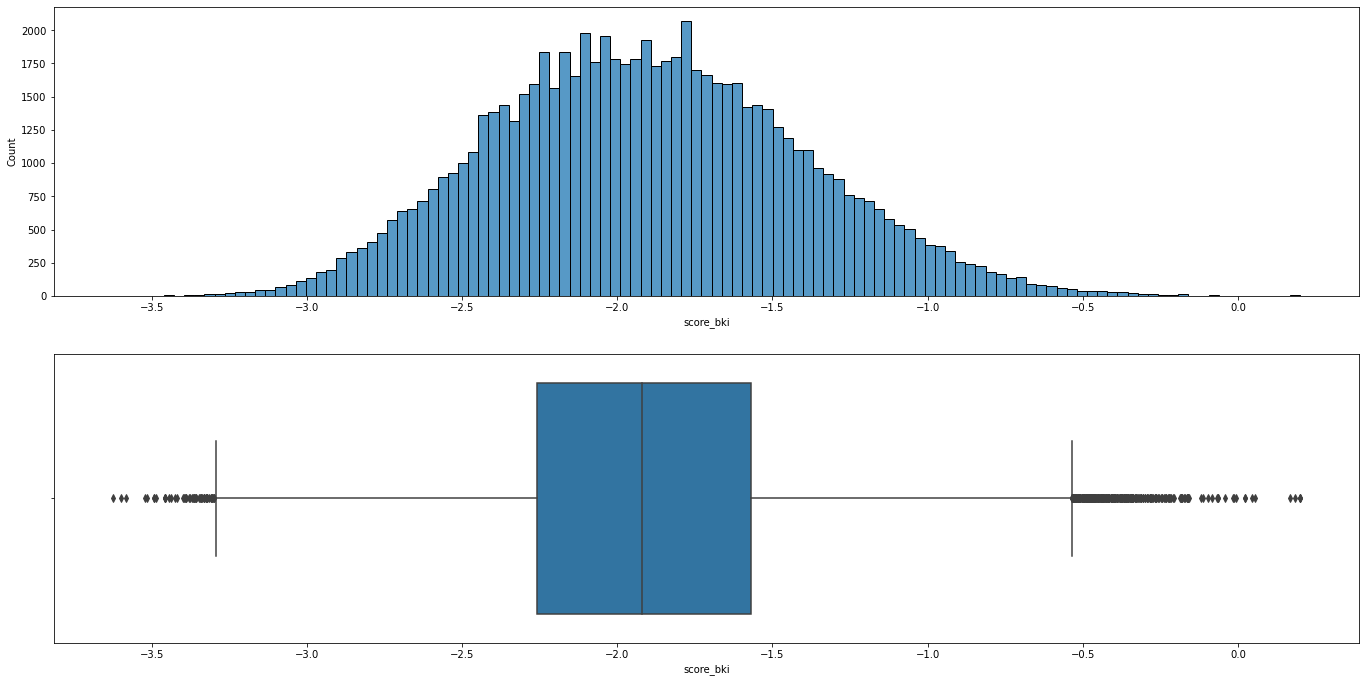

In [49]:
outliers = display_variable_info(
    pre_data[pre_data["sample"] == 1], "score_bki",
    [
        "histogram", "boxplot"
    ],
    target_column_name="default",
    calculate_outliers=True,
    figsize_inches=(23.4, 11.7)
)
outliers_dictionary["score_bki"] = outliers

##### Выбросы

In [50]:
print(outliers_dictionary["score_bki"]["outliers_text"])

Outliers information for column score_bki:
OrderedDict([('column_name', 'score_bki'),
             ('column_size', 73799),
             ('MIN', -3.62458632),
             ('Q1', -2.259533835),
             ('median', -1.92082293),
             ('Q3', -1.56983126),
             ('MAX', 0.19977285),
             ('IQR', 0.6897025750000001),
             ('left_boundary', -3.2940876975),
             ('right_boundary', -0.5352773974999998),
             ('number_of_outliers', 351),
             ('outliers_percent', 0.476),
             ('outliers_value_counts_top_10',
              -3.330242    4
-3.456086    3
-3.358230    2
-0.376546    2
-3.310293    2
 0.199773    2
-3.320406    2
-0.218476    1
-0.489043    1
-0.528836    1
Name: score_bki, dtype: int64),
             ('outliers',
              56      -0.500103
80      -0.266137
235     -0.275273
429     -0.523215
446     -0.523830
           ...   
72993   -0.012303
73265   -0.470095
73367   -0.281990
73478   -3.395724
73644   -0.4

#### `decline_app_cnt`

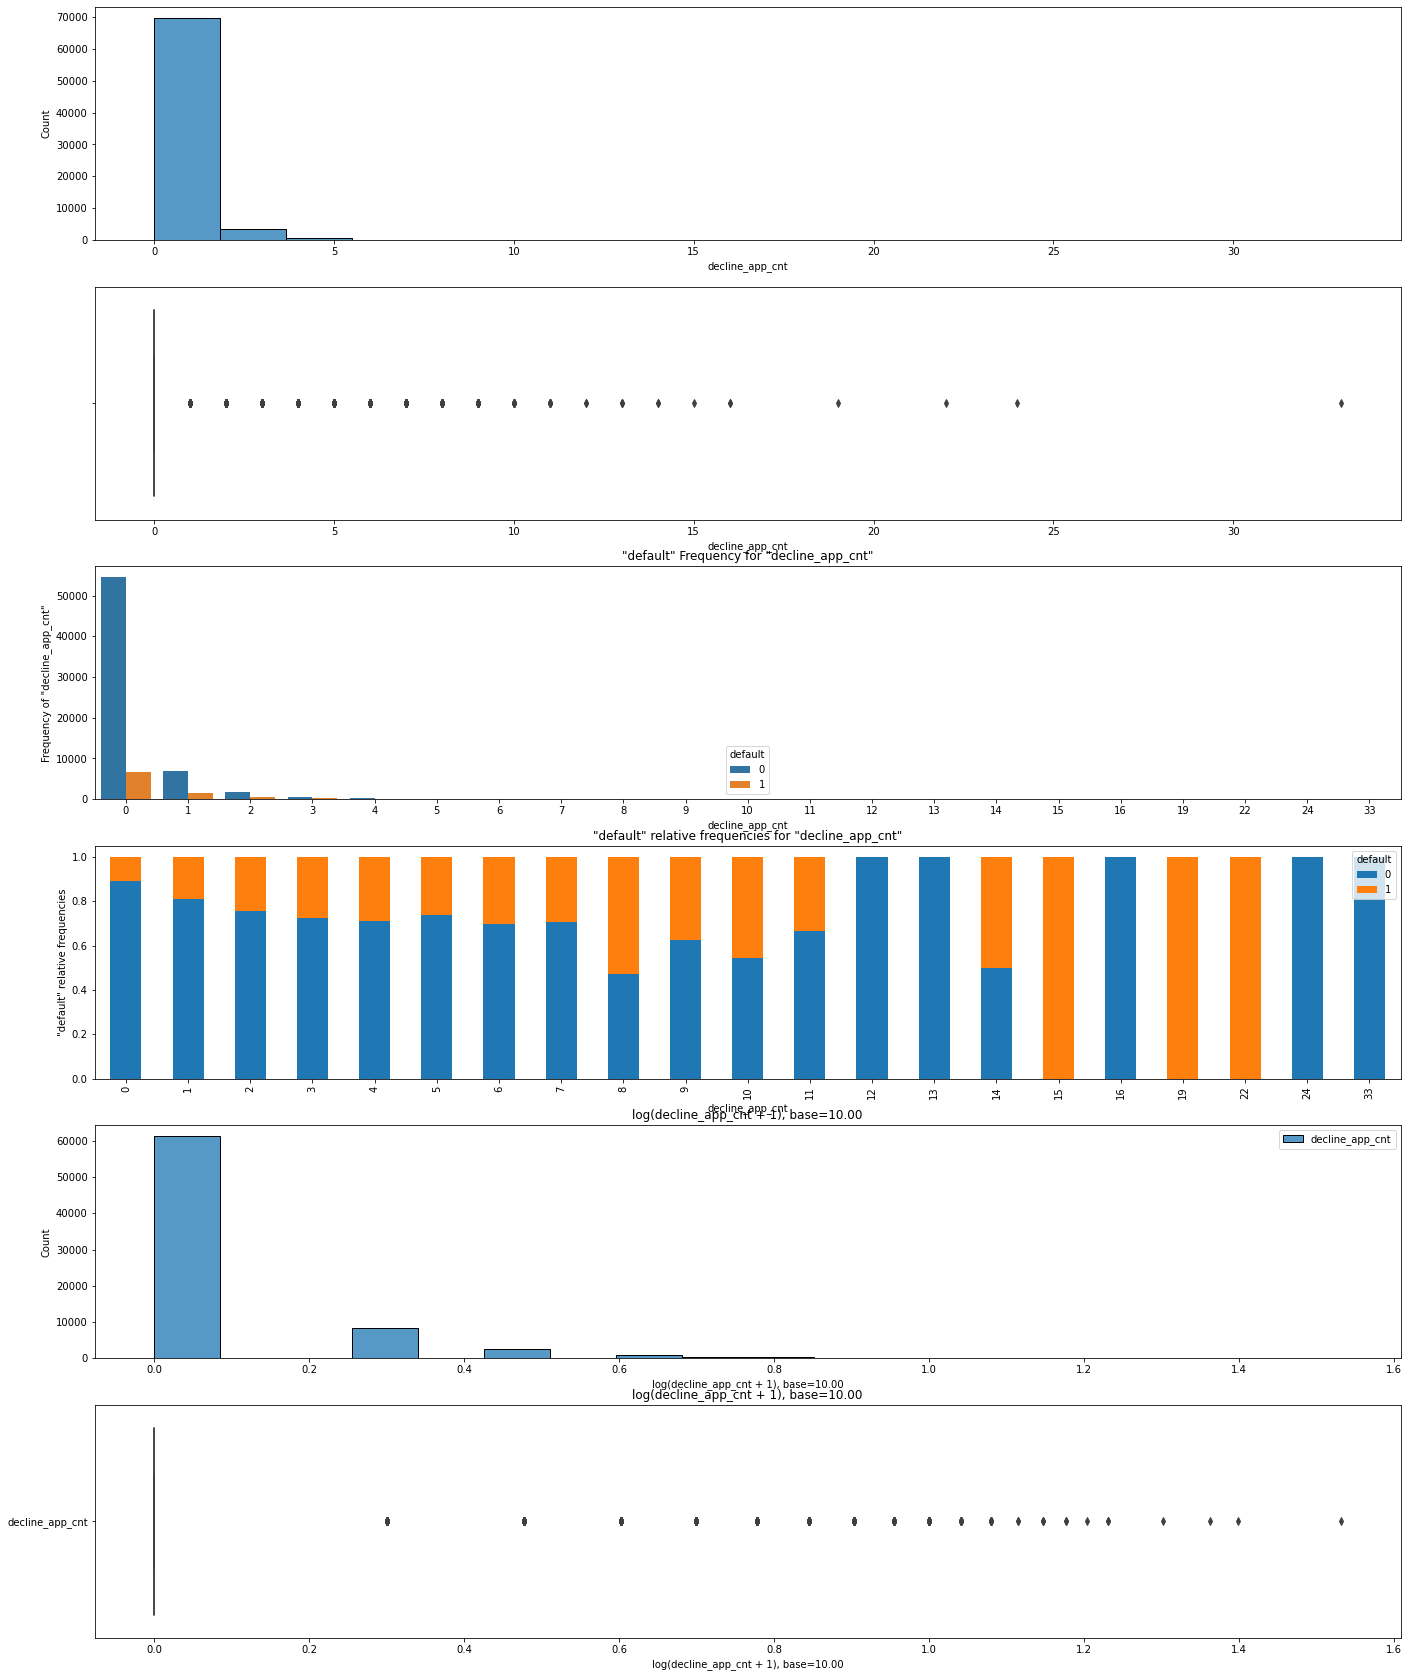

In [51]:
outliers = display_variable_info(
    pre_data[pre_data["sample"] == 1], "decline_app_cnt",
    [
        "histogram", "boxplot",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=True,
    plot_extra_logscale=10,
    log_x_plus_one=True,
    figsize_inches=(23.4, 30.0)
)
outliers_dictionary["decline_app_cnt"] = outliers

##### Выбросы, влючая попытку логарифмирования

In [52]:
print(outliers_dictionary["decline_app_cnt"]["outliers_text"])

Outliers information for column decline_app_cnt:
OrderedDict([('column_name', 'decline_app_cnt'),
             ('column_size', 73799),
             ('MIN', 0),
             ('Q1', 0.0),
             ('median', 0.0),
             ('Q3', 0.0),
             ('MAX', 33),
             ('IQR', 0.0),
             ('left_boundary', 0.0),
             ('right_boundary', 0.0),
             ('number_of_outliers', 12585),
             ('outliers_percent', 17.053),
             ('outliers_value_counts_top_10',
              1     8397
2     2468
3      903
4      414
5      165
6      113
7       48
9       24
8       19
10      11
Name: decline_app_cnt, dtype: int64),
             ('outliers',
              2        2
8        1
10       2
33       2
38       1
        ..
73757    2
73762    1
73771    3
73776    4
73782    2
Name: decline_app_cnt, Length: 12585, dtype: int64)])
Outliers information for column log(decline_app_cnt + 1), base=10.00:
OrderedDict([('column_name', 'decline_app_cnt'),
 

#### `bki_request_cnt`

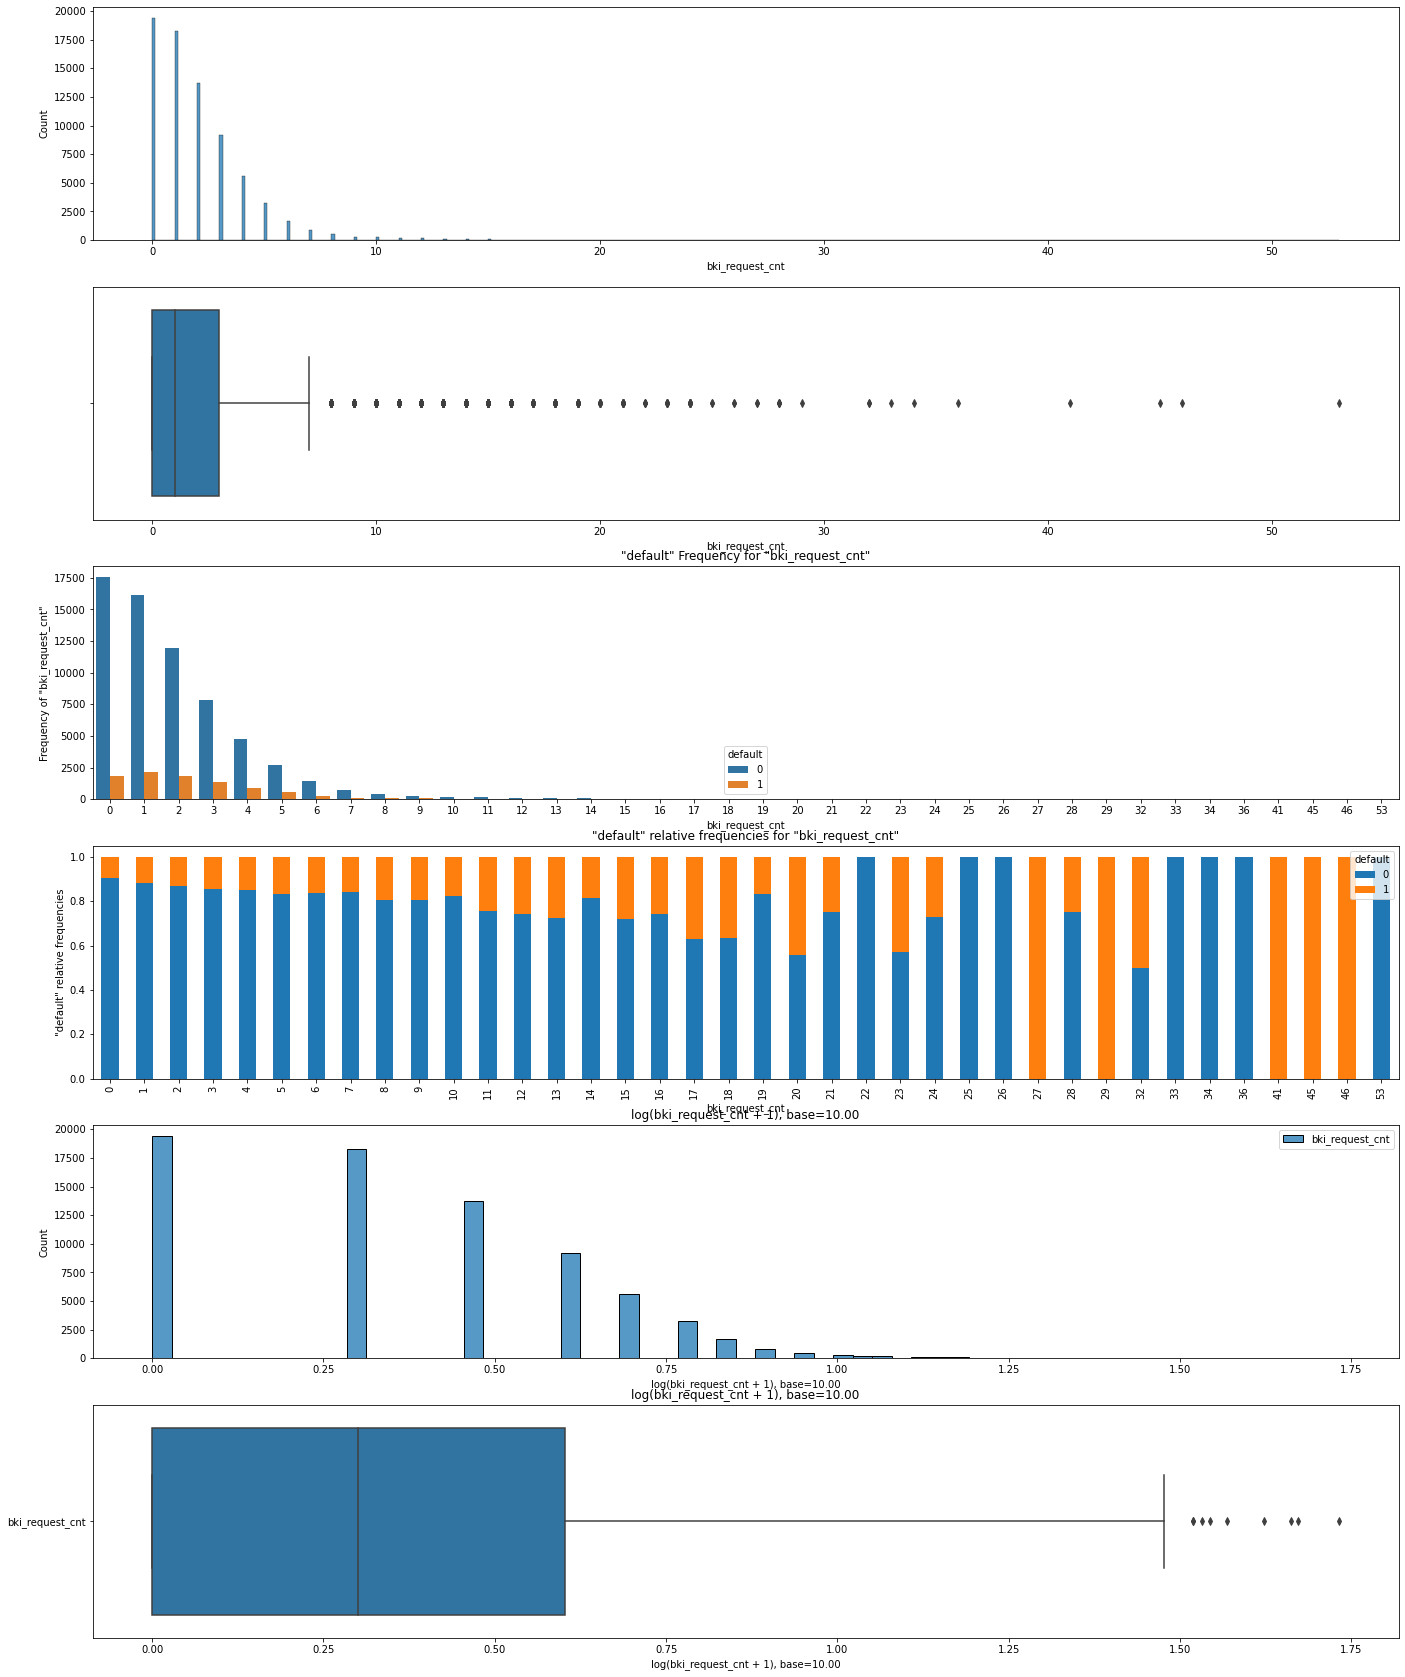

In [53]:
outliers = display_variable_info(
    pre_data[pre_data["sample"] == 1], "bki_request_cnt",
    [
        "histogram", "boxplot",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=True,
    plot_extra_logscale=10,
    log_x_plus_one=True,
    figsize_inches=(23.4, 30.0)
)
outliers_dictionary["bki_request_cnt"] = outliers

##### Выбросы, влючая попытку логарифмирования

In [54]:
print(outliers_dictionary["bki_request_cnt"]["outliers_text"])

Outliers information for column bki_request_cnt:
OrderedDict([('column_name', 'bki_request_cnt'),
             ('column_size', 73799),
             ('MIN', 0),
             ('Q1', 0.0),
             ('median', 1.0),
             ('Q3', 3.0),
             ('MAX', 53),
             ('IQR', 3.0),
             ('left_boundary', -4.5),
             ('right_boundary', 7.5),
             ('number_of_outliers', 1755),
             ('outliers_percent', 2.378),
             ('outliers_value_counts_top_10',
              8     508
9     299
10    225
11    188
12    144
13     94
14     86
15     54
16     35
18     22
Name: bki_request_cnt, dtype: int64),
             ('outliers',
              54        8
107      13
114       8
185      13
188      10
         ..
73334    11
73412    28
73461    23
73679     8
73771    12
Name: bki_request_cnt, Length: 1755, dtype: int64)])
Outliers information for column log(bki_request_cnt + 1), base=10.00:
OrderedDict([('column_name', 'bki_request_cnt'),
  

#### `income`

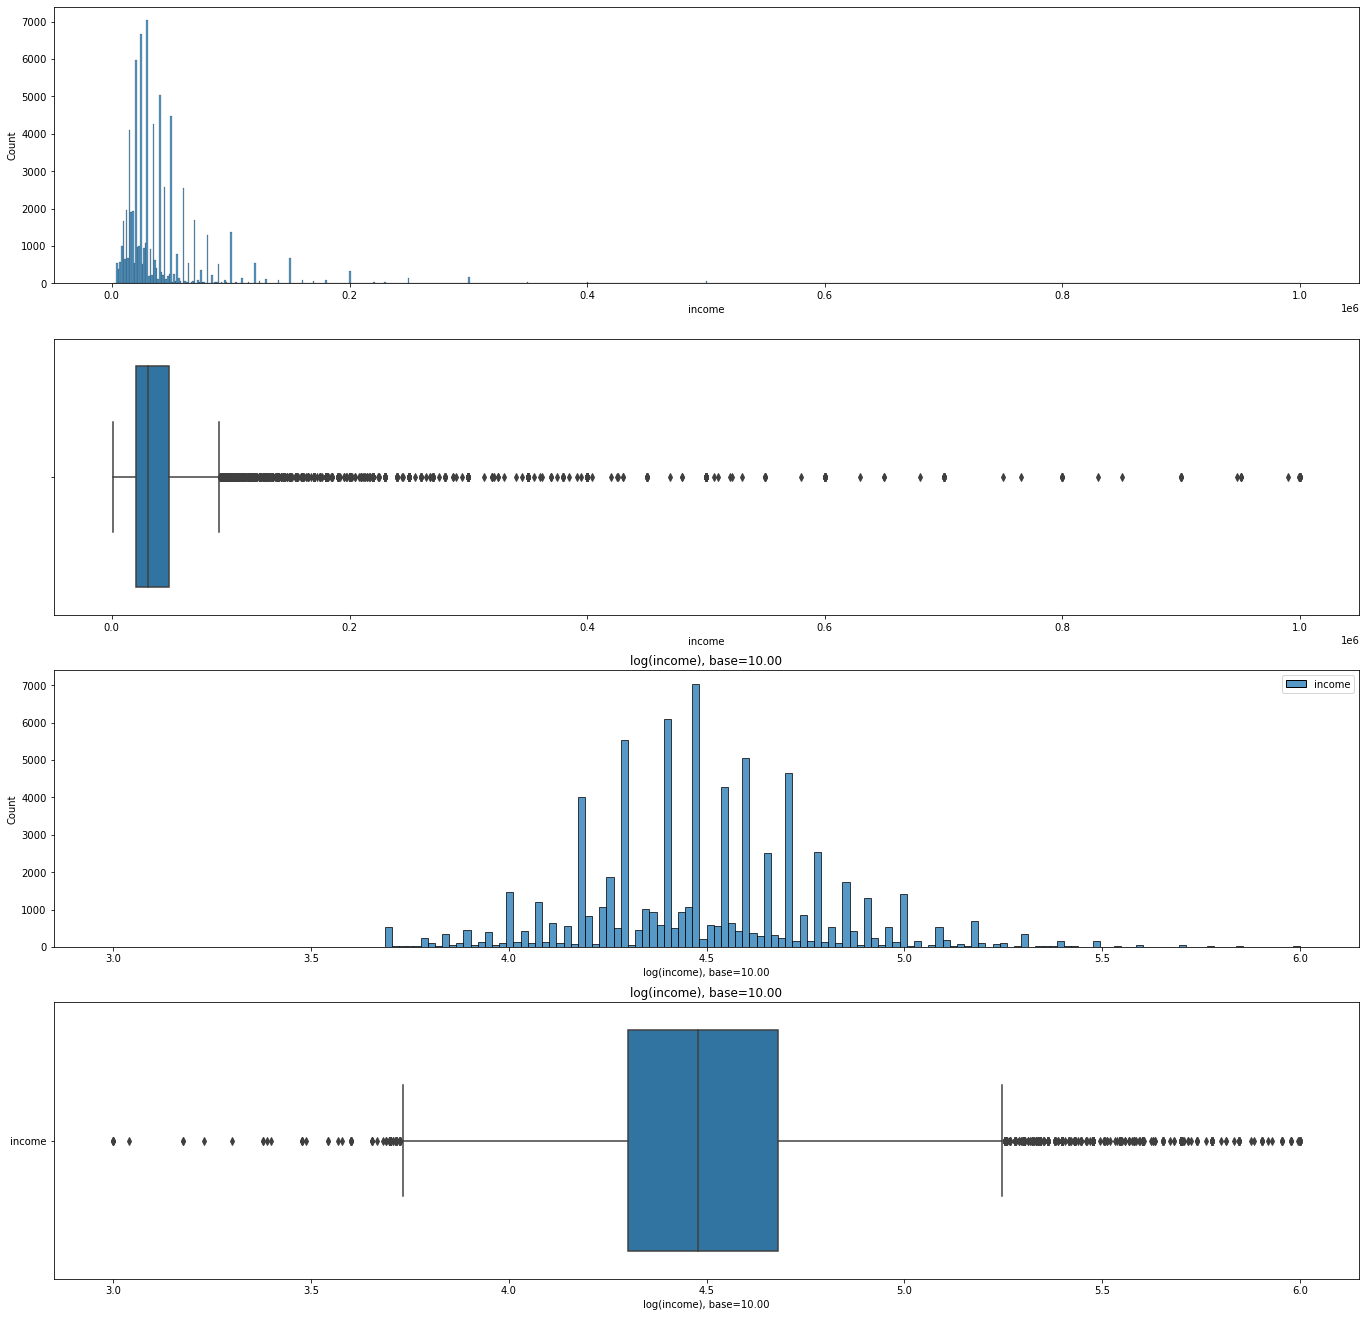

In [55]:
outliers = display_variable_info(
    pre_data[pre_data["sample"] == 1], "income",
    [
        "histogram", "boxplot"
    ],
    calculate_outliers=True,
    plot_extra_logscale=10,
    log_x_plus_one=False,
    figsize_inches=(23.4, 23.4)
)
outliers_dictionary["income"] = outliers

##### Выбросы, влючая попытку логарифмирования

In [56]:
print(outliers_dictionary["income"]["outliers_text"])

Outliers information for column income:
OrderedDict([('column_name', 'income'),
             ('column_size', 73799),
             ('MIN', 1000),
             ('Q1', 20000.0),
             ('median', 30000.0),
             ('Q3', 48000.0),
             ('MAX', 1000000),
             ('IQR', 28000.0),
             ('left_boundary', -22000.0),
             ('right_boundary', 90000.0),
             ('number_of_outliers', 4695),
             ('outliers_percent', 6.362),
             ('outliers_value_counts_top_10',
              100000    1381
150000     680
120000     531
200000     341
300000     169
250000     146
110000     135
130000     117
180000      86
95000       83
Name: income, dtype: int64),
             ('outliers',
              28       100000
54       200000
67       130000
72       350000
76       100000
          ...  
73731    200000
73739    120000
73740    200000
73749    120000
73790    100600
Name: income, Length: 4695, dtype: int64)])
Outliers information for column

#### `age`

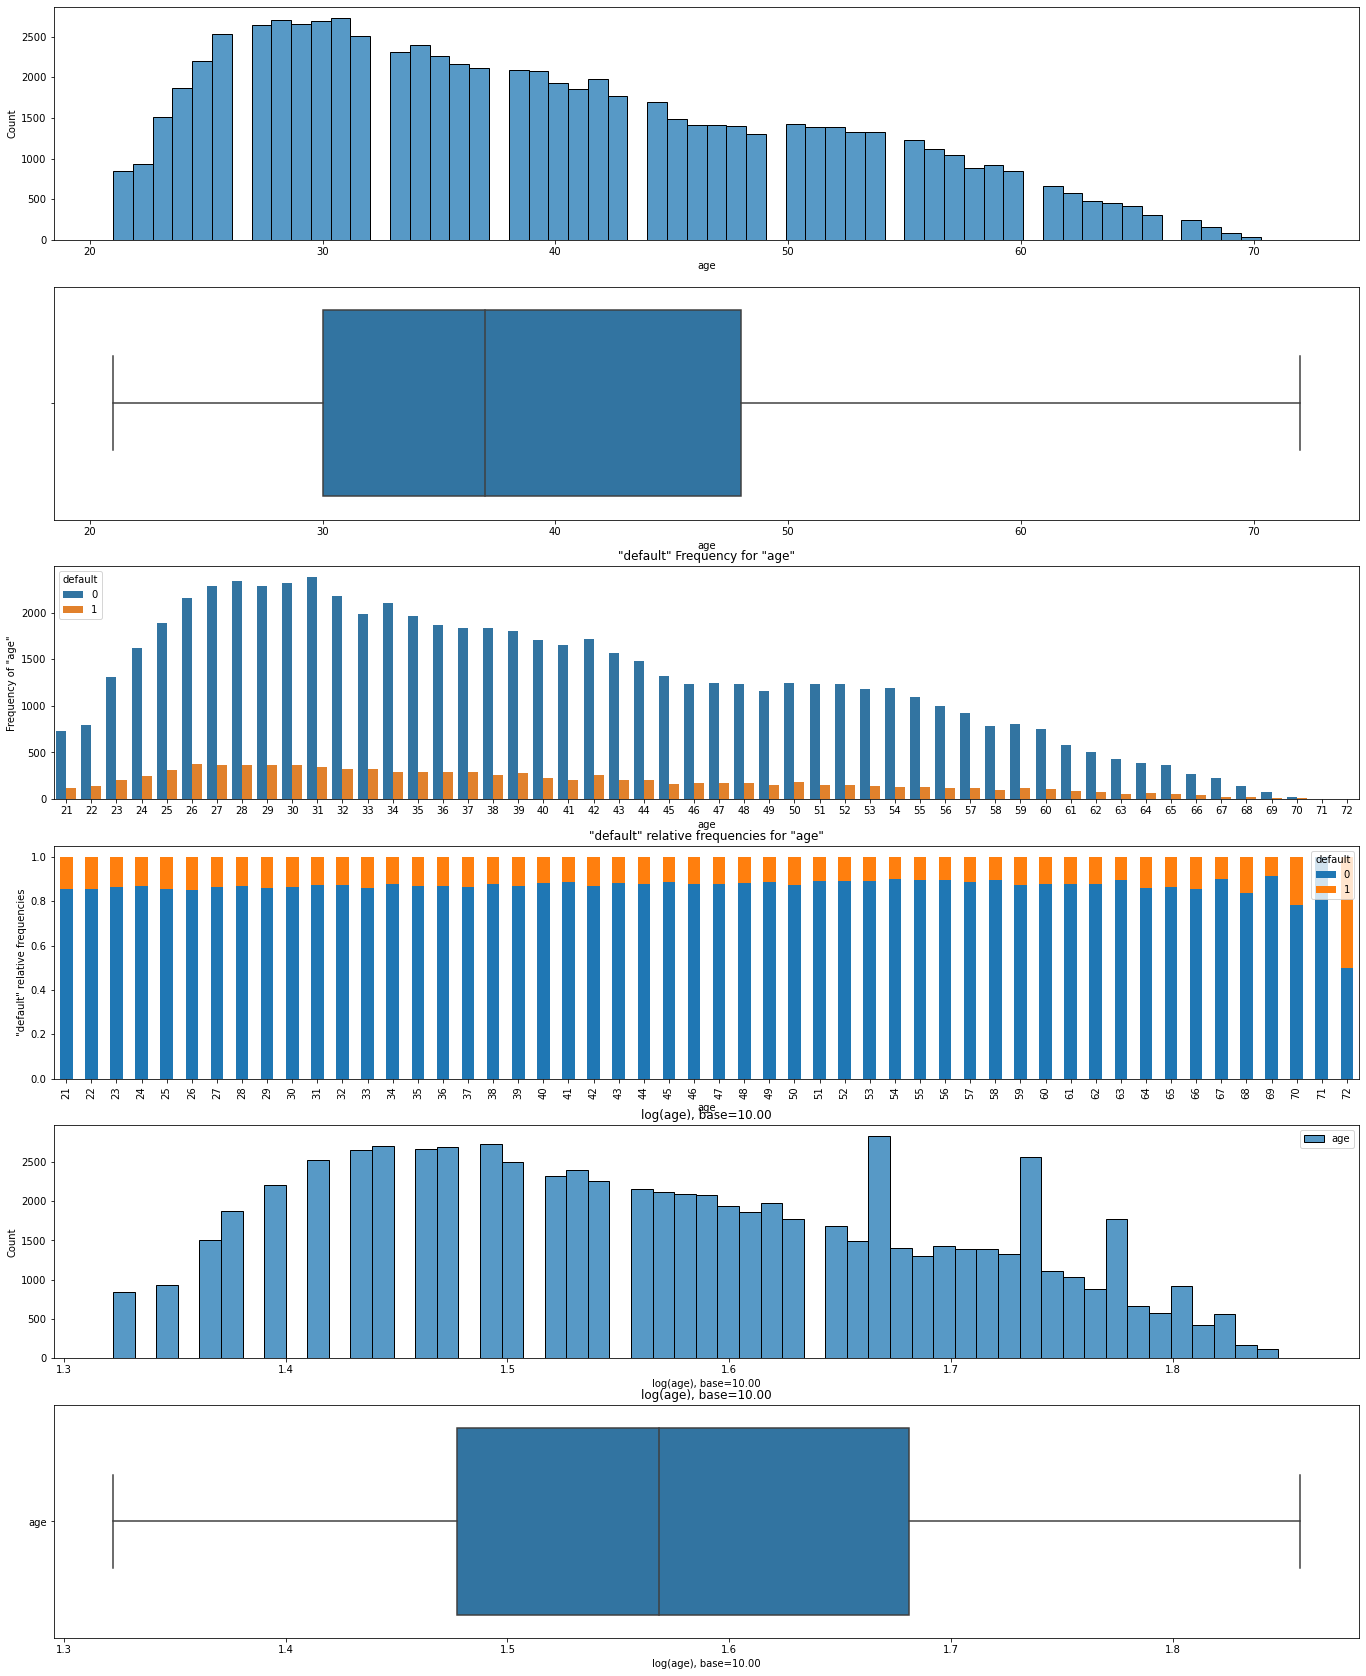

In [57]:
outliers = display_variable_info(
    pre_data[pre_data["sample"] == 1], "age",
    [
        "histogram", "boxplot",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=True,
    plot_extra_logscale=10,
    figsize_inches=(23.4, 30.0)
)
outliers_dictionary["age"] = outliers

In [58]:
print(outliers_dictionary["age"]["outliers_text"])

Outliers information for column age:
OrderedDict([('column_name', 'age'),
             ('column_size', 73799),
             ('MIN', 21),
             ('Q1', 30.0),
             ('median', 37.0),
             ('Q3', 48.0),
             ('MAX', 72),
             ('IQR', 18.0),
             ('left_boundary', 3.0),
             ('right_boundary', 75.0),
             ('number_of_outliers', 0),
             ('outliers_percent', 0.0),
             ('outliers_value_counts_top_10',
              Series([], Name: age, dtype: int64)),
             ('outliers', Series([], Name: age, dtype: int64))])
Outliers information for column log(age), base=10.00:
OrderedDict([('column_name', 'age'),
             ('column_size', 73799),
             ('MIN', 1.322219294733919),
             ('Q1', 1.4771212547196624),
             ('median', 1.5682017240669948),
             ('Q3', 1.6812412373755872),
             ('MAX', 1.8573324964312683),
             ('IQR', 0.2041199826559248),
             ('left_bound

#### Выводы по преобразованию данных для числовых переменных

##### `score_bki`
Распределение изначально близко к нормальному.
Применять логарифмирование ненужно.
Имеется всего `351` выброс, что составляет `0.476` % от объёма тренировочной выборки.
Эти выбросы можно удалить.

**Действия:**
- удаление строк с выбросами для `score_bki`;
- стандартизация переменной `score_bki`.

##### `decline_app_cnt`
Распределение похоже на экспоненциальное и не может быть успешно логарифмировано.
Число выбросов на основе критерия межквартильного размаха
составляет примерно `17` % от объёма тренировочной выборки.
При этом в выбросы попадают все значения отличные от единственного
"неаномального" значения `0`.
Возможно, что переменнная decline_app_cnt (число отказов по кредиту)
завист от неких двух других случайных величин, которые пока не представляется возможным
исследовать.

Все полученные для этой переменноу выбросами решено таковыми не считать,
поскольку на самом дле они могут быть существенной частью модели.

**Действия:**
- стандартизация переменной `decline_app_cnt`.


##### `bki_request_cnt`
Распределение отлично и от экспоненциального и от (лог)нормального.
Имеется всего `1755` выброс, что составляет `2.378` % от объёма тренировочной выборки.
Логарифмирование привело к снижению числа выбросов до `9` штук.

**Действия:**
- логарифмирование `bki_request_cnt`;
- удаление строк с выбросами для `bki_request_cnt`;
- стандартизация переменной `bki_request_cnt`.

##### `income`
Распределение близко к логнормальному.
При пременении логарифмирования произожно устранения характерного сильногго смещения вправо.
Имеется всего `4695` выброса, что составляет `6.362` % от объёма тренировочной выборки.
Логарифмирование привело к снижению числа выбросов до `1767` (`2.394`%).
При этом по предыдущим итерациям обучения модели, включая тренировочный проект,
устранение больших зарплат из выборки приводит к ухудшению предсказательной способности модели.

**Действия:**
- логарифмирование `income`;
- стандартизация переменной `income`.

##### `age`
В переменной `age` нет выбросов. Логарифмирование не привело к приведению к нормальному распределению.

**Действия:**
- стандартизация переменной `age`.

#### Корреляции числовых переменных

<AxesSubplot:>

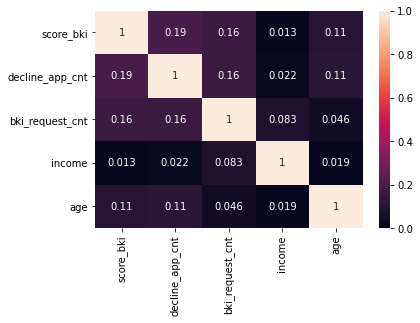

In [59]:
sns.heatmap(
    pre_data[pre_data["sample"] == 1][numerical_columns].corr().abs(),
    annot=True, vmin=0, vmax=1
)

In [60]:
pre_data[pre_data["sample"] == 1][numerical_columns].corr()

score_bki  decline_app_cnt  bki_request_cnt    income  \
score_bki         1.000000         0.189987         0.156257 -0.012639   
decline_app_cnt   0.189987         1.000000         0.155894 -0.021687   
bki_request_cnt   0.156257         0.155894         1.000000  0.082983   
income           -0.012639        -0.021687         0.082983  1.000000   
age              -0.106275        -0.111175         0.046265 -0.018900   

                      age  
score_bki       -0.106275  
decline_app_cnt -0.111175  
bki_request_cnt  0.046265  
income          -0.018900  
age              1.000000

Количество отказов по выдаче кредита коррелирует положительно с рейтингом клиента в БКИ и числом запросов в базу БКИ. Есть некоторая отрицательная корреляция рейтинга БКИ и возраста клиента.
Также отрицательно коррелируют число отказов и возраст.
Требуется дополнительный анализ значимости числовых переменных
для включения в итоговый датасет модели.
Например на основе однофакторного дисперсионного анализа.

#### Значимость числовый переменных

<AxesSubplot:>

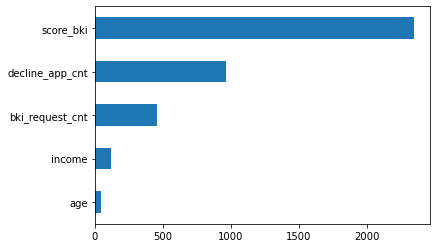

In [61]:
imp_num = pd.Series(
    f_classif(
        pre_data[pre_data["sample"] == 1][numerical_columns],
        pre_data[pre_data["sample"] == 1]['default']
    )[0],
    index = numerical_columns
)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

##### Выводы
Применение однофакторного дисперсионного анализа показало, что
самой значимой переменной является переменная `score_bki` (рейтинга бюро кредитных историй).
Другие два признака, которые нужно также принимать во внимание -
`declain_app_cnt` (число предыдущих отказов) и `bki_request_cnt`
(добавляет подозрительности к анкете клиента).

`income` и `age` могут несущественно влиять на значение метрики при обучении.

**Действия**
- оставить в итоговой модели только переменные `score_bki`, `declain_app_cnt`, `bki_request_cnt`.

### Категориальные и бинарные переменные

Для простоты рассмотрения корреляция и значимости рассмотрим тренировочную выборку без dummy признаков.

#### Ординальные переменные

In [62]:
ordinal_columns

['region_rating', 'sna', 'first_time', 'education']

##### `region_rating`

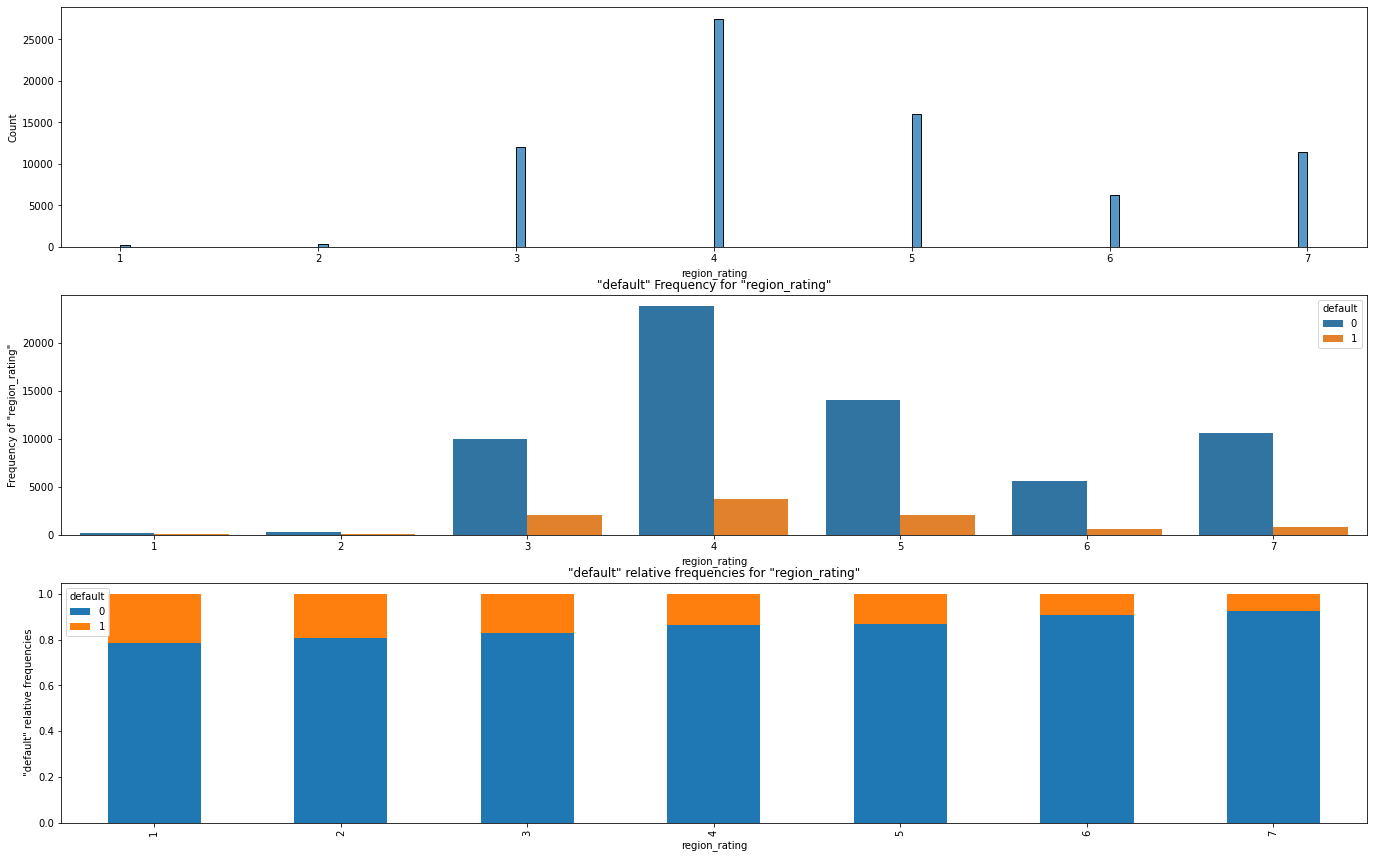

In [63]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "region_rating",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

Видна чёткая положительная корреляция между увеличением рейтинга региона и<br /> увеличением частоты возврата кредитов.<br />
Возможно, что `region_rating` - хорошая переменная для модели логистической регрессии.

##### `sna`

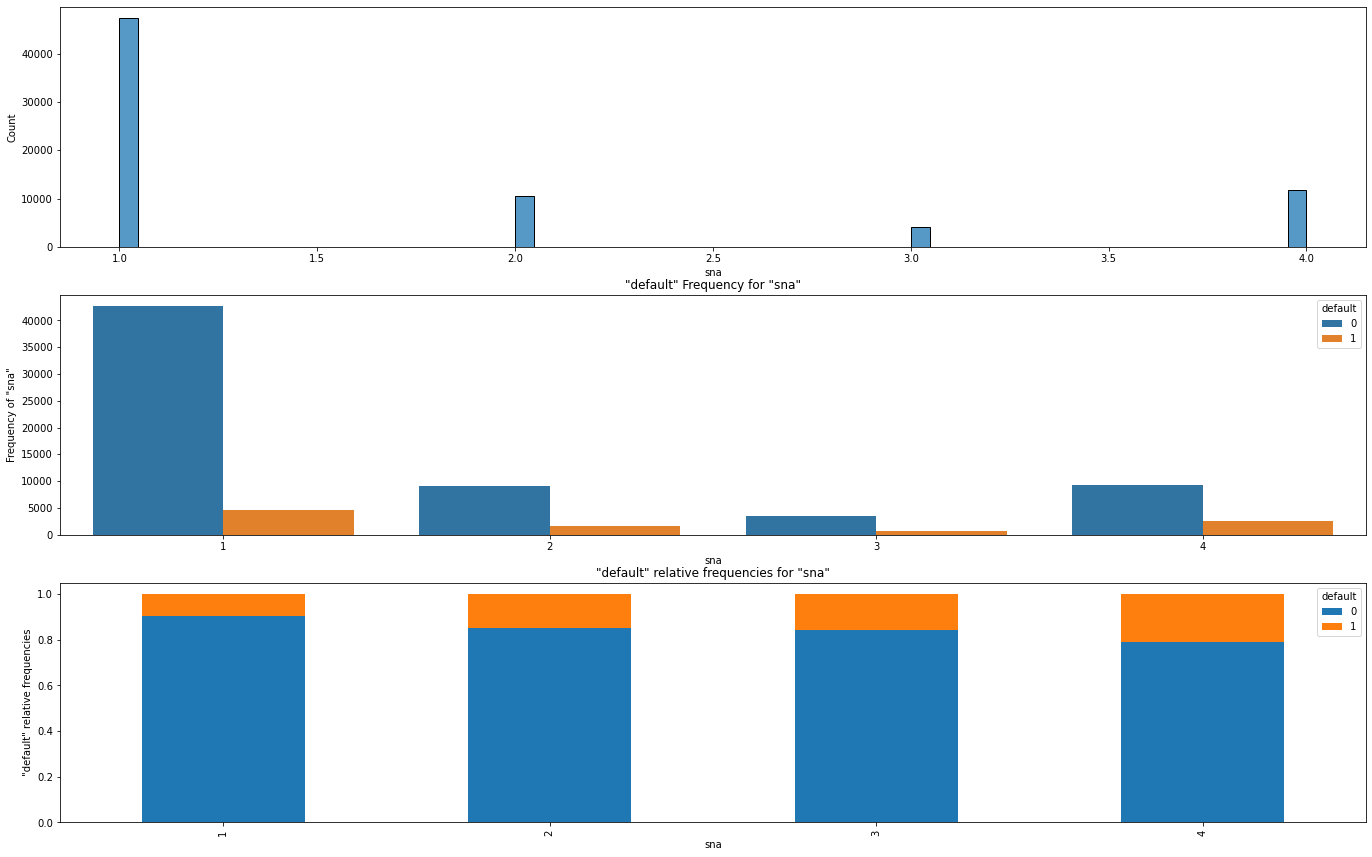

In [64]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "sna",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

Чем больше у клиента связей с такими же клиентами как он, тем отношение дефолтов к погашениям больше. Возможно это показатель некой более высокой активности и рискованности таких заёмщиков в рамках подачи заявок на займы в этом банке. Но шкала этого показателя требует б'ольший разъяснений.

##### `first_time`

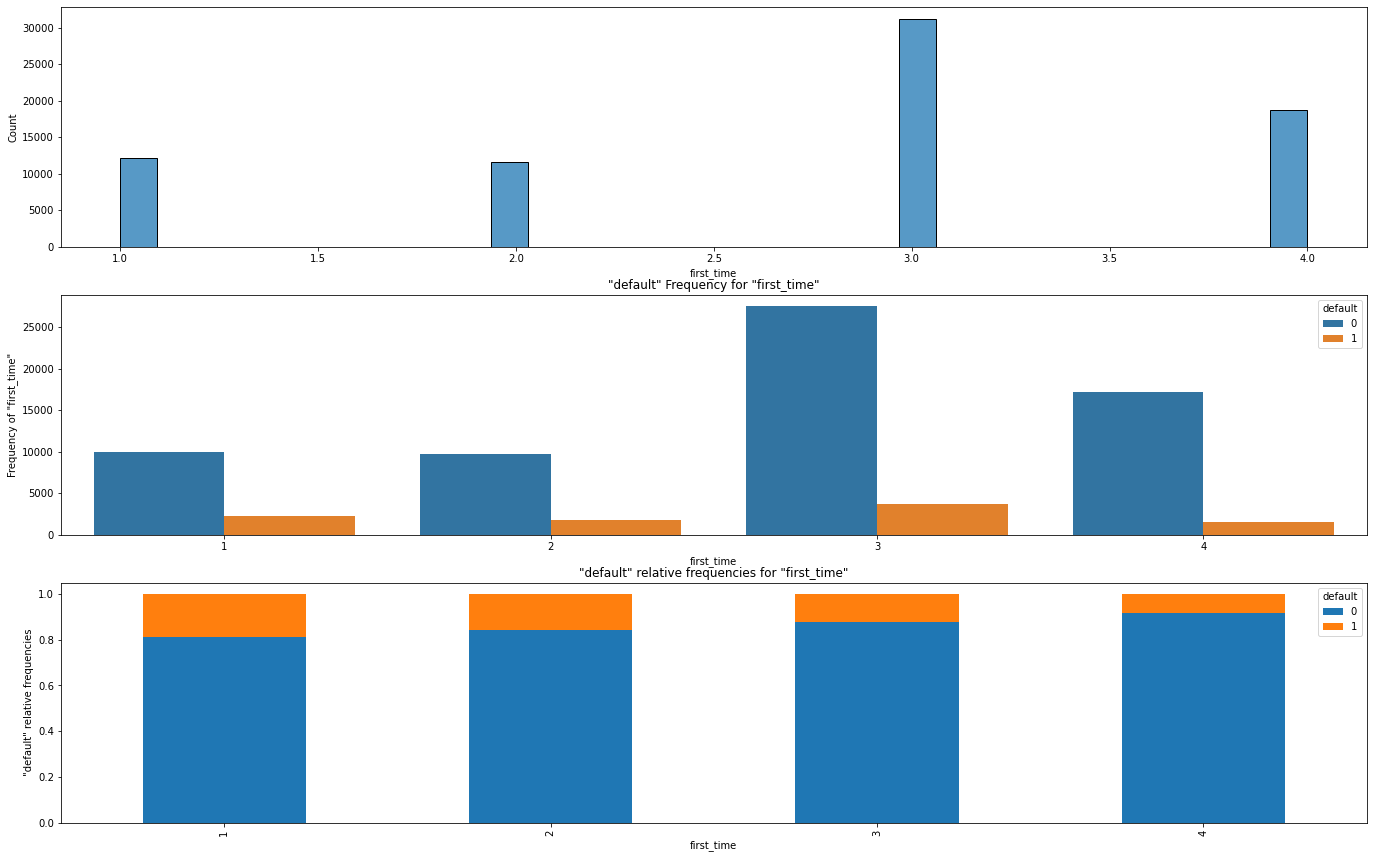

In [65]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "first_time",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

Больше всего заёмщиков из 3-й, относительно "центральной" категогии давности.<br />
При этом видна положительная корреляция между увеличенией срока<br />
как давно банку известно о клиенте и увеличением относительной частоты возвратов кредитов.<br/>
К отношении положительного, в данной модели, класса дефолтов `1` коорреляция,<br />
конечно, отрицательная.

##### `education`

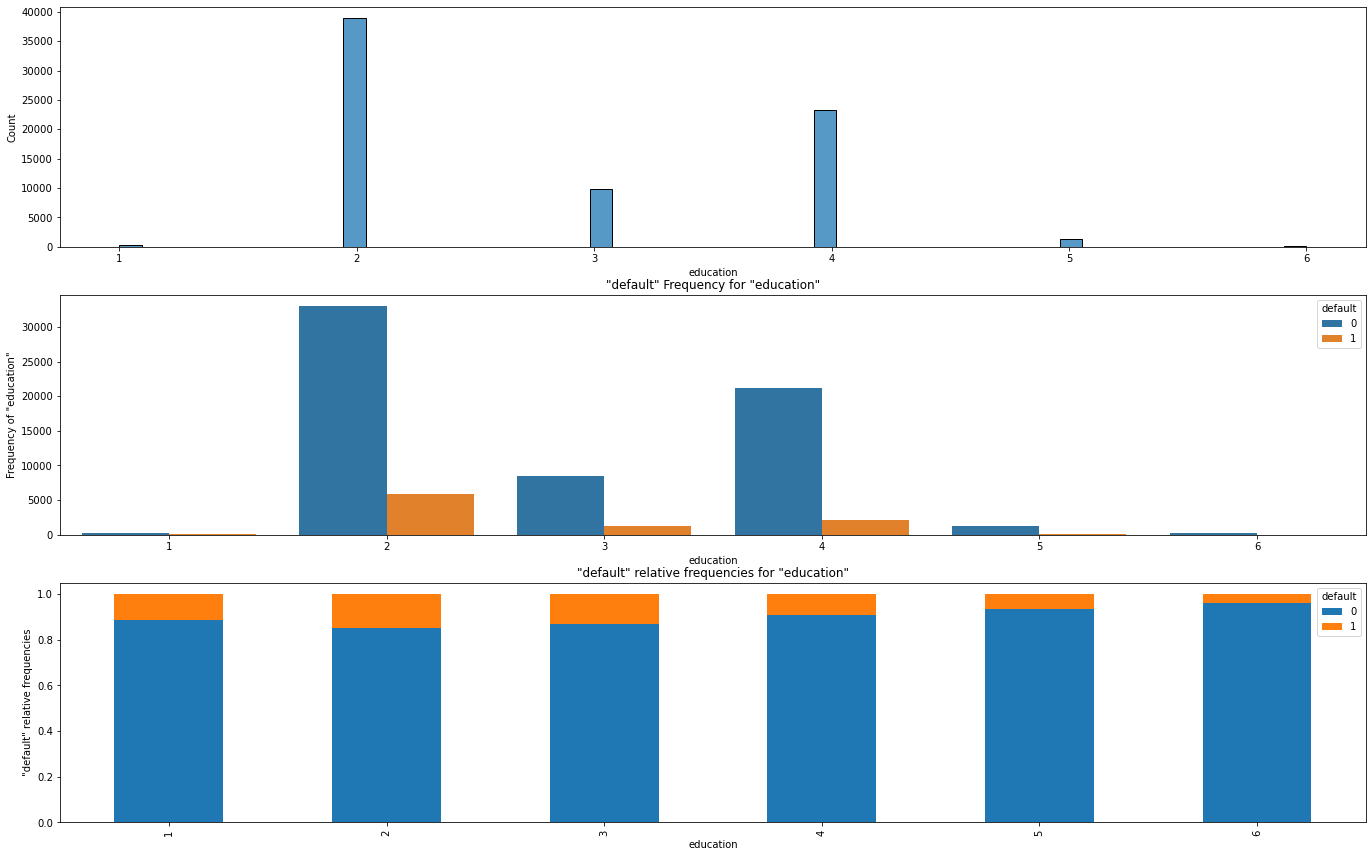

In [66]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "education",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

Чаще дефолт происходит у людей:
- со школьным образованием (`SCH` - 2);
- с дипломами бакалавра (undergraduate, `UGR` - 3);
- с людьми, которые не указали уровень своего образования (`NULL` - 1).

Меньше всего дефолтов у людей:
- с учёной степенью (academic, `ACD` - 6);
- со степенью магистра (post graduate, `PGR` - 5);
- магистрантов (graduate, `GRD` - 4).

Категория `NULL` выбивается из общей тенденции, но<br />
её можно искусственно считать самой "подозрительной" категорией в этой переменной,<br />
если подающий заявку не заполнил эту графу анкеты.

#### Номинативные переменные

In [67]:
nominal_columns

['home_address', 'work_address']

##### `home_address`

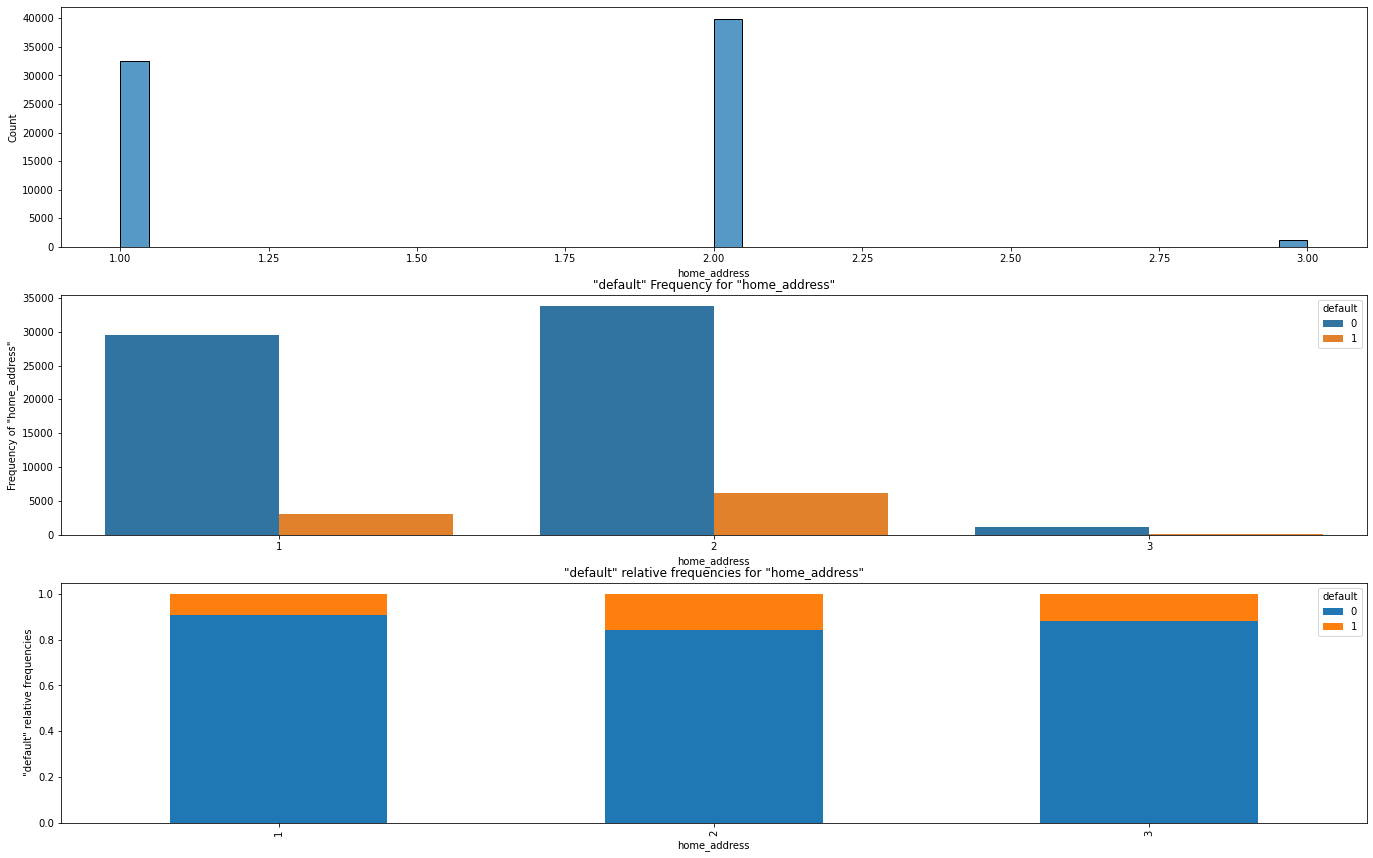

In [68]:
display_variable_info(
    pre_data_no_dummies[pre_data_no_dummies["sample"] == 1], "home_address",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

По поводу зависимости относительной частоты дефолтов от номера категории<br />
домашнего адреса нельзя увидеть чёткой зависимости.<br />
Это просто коррелирует с самым большим количеством людей из этой категории.

##### `work_address`

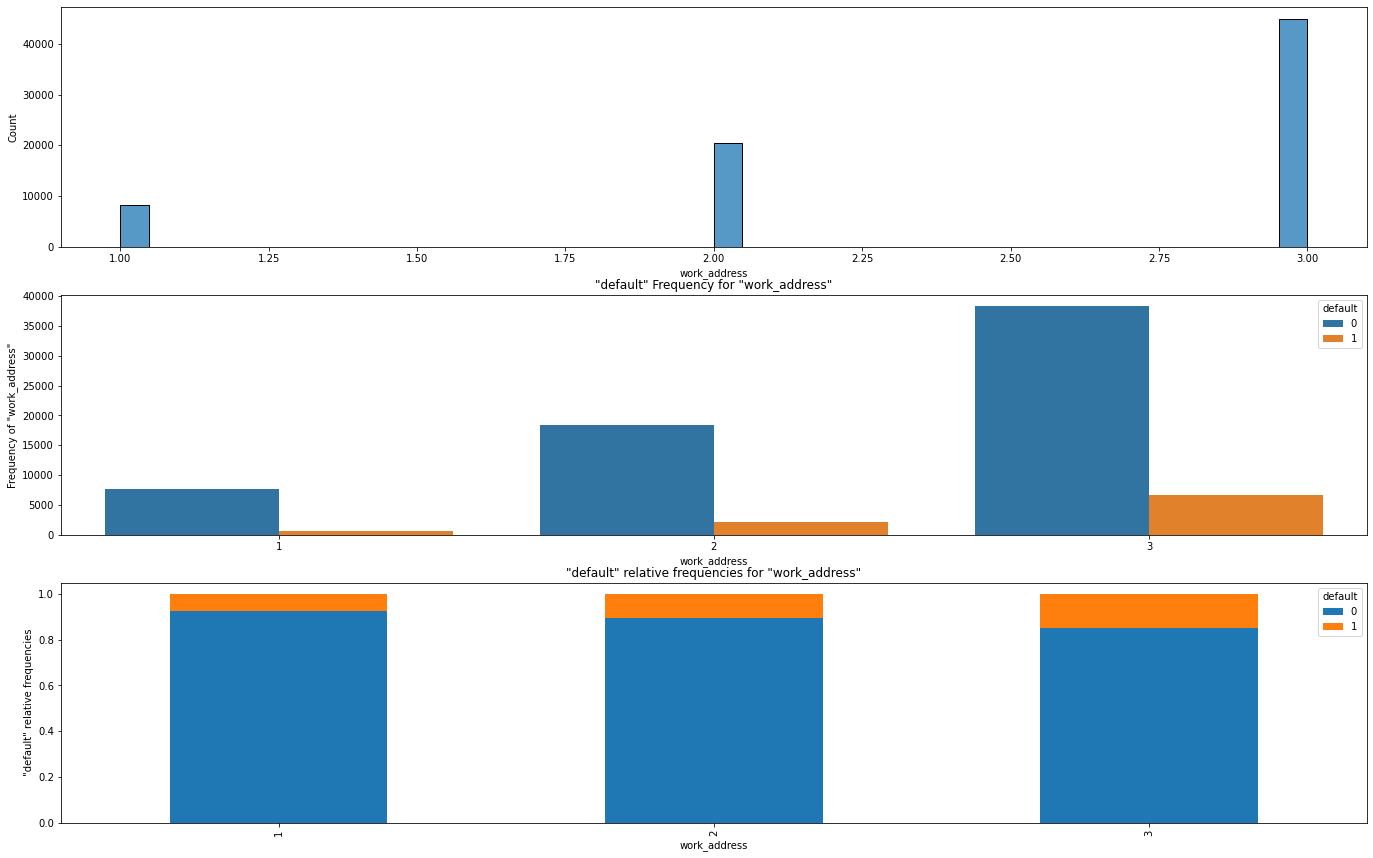

In [69]:
display_variable_info(
    pre_data_no_dummies[pre_data_no_dummies["sample"] == 1], "work_address",
    [
        "histogram",
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

С возрастанием номера категории адреса работы возрастает относительная частота дефолтов.<br />
Это просто коррелирует с самым большим количеством людей из этой категории.

#### Бинарные признаки

In [70]:
binary_columns

['good_work', 'car', 'car_type', 'foreign_passport', 'sex_male']

##### `good_work`

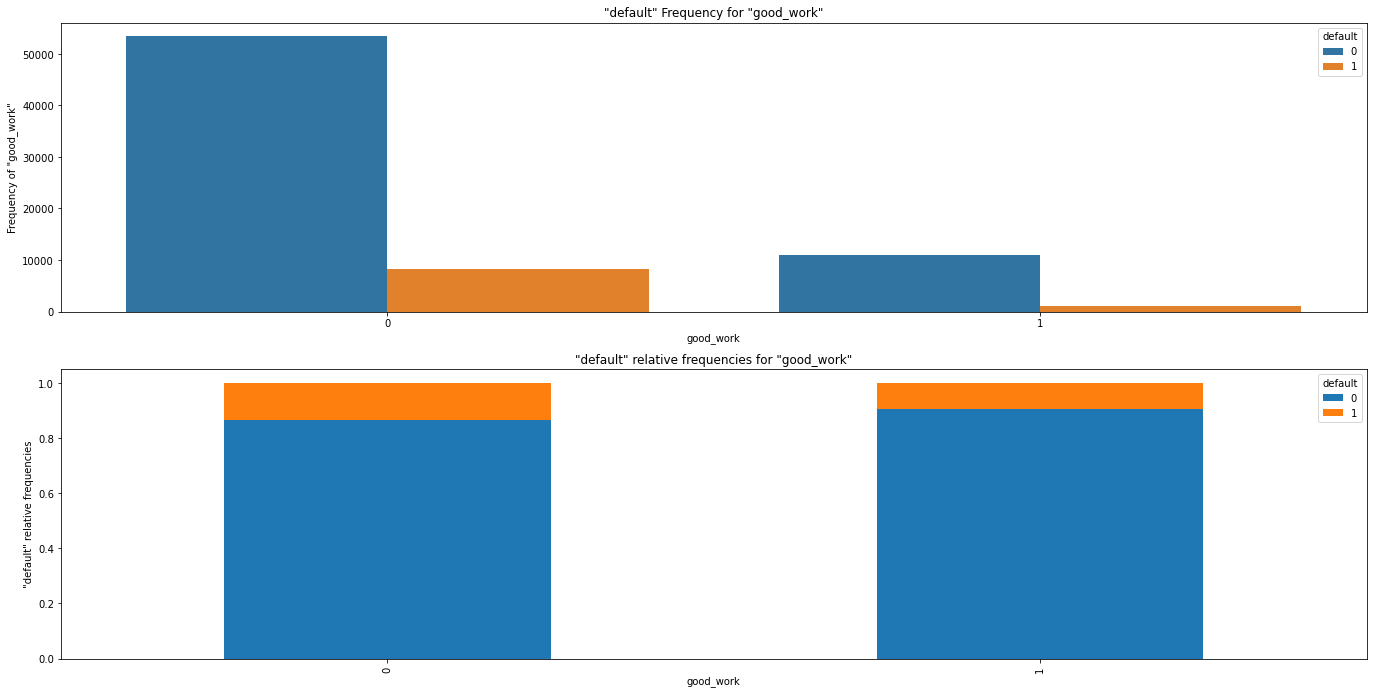

In [71]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "good_work",
    [
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 11.7)
)

Видно только, что те, у кого хорошая работа меньше, имеют меньшую относительную частоту дефолтов. Также они меньше представлены в выборке, то есть меньше берут кредитов. Но из выборки не понятно насколько велики кредиты у людей  большими доходами.

##### `car`

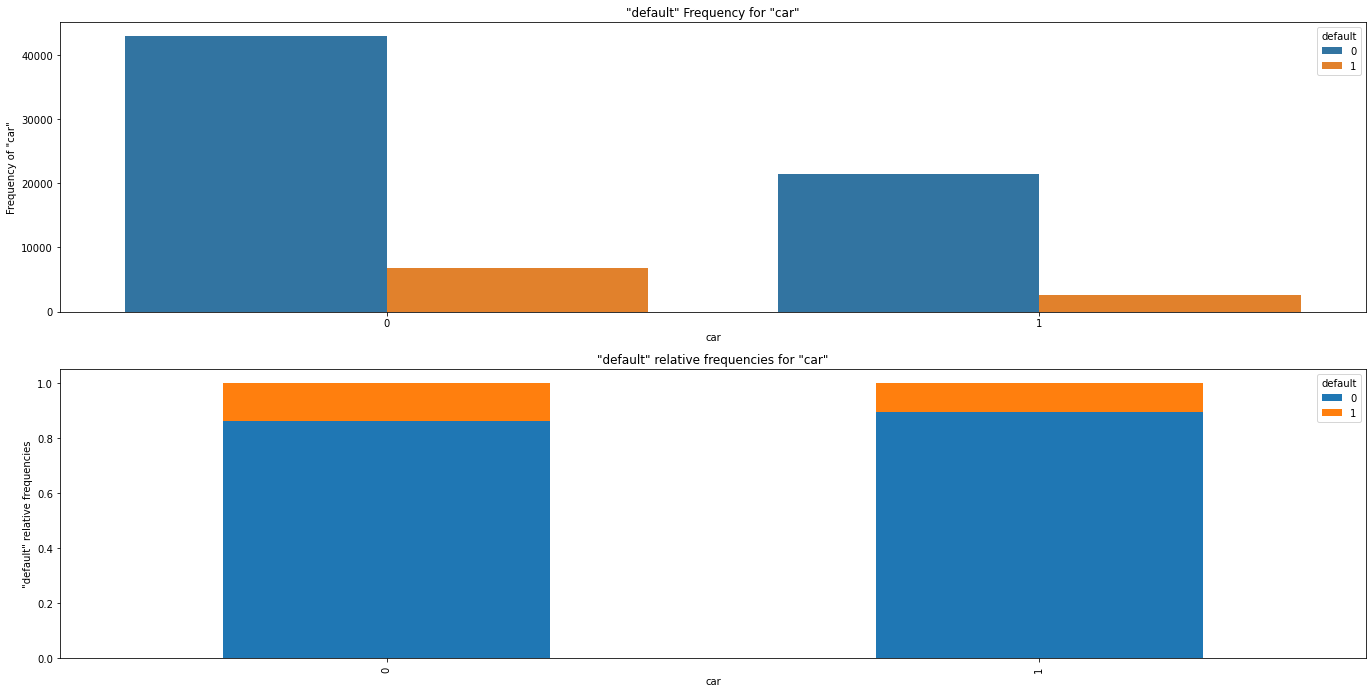

In [72]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "car",
    [
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 11.7)
)

Относительная частота дефолтов у людей савтомобилем меньше.

##### `car_type`

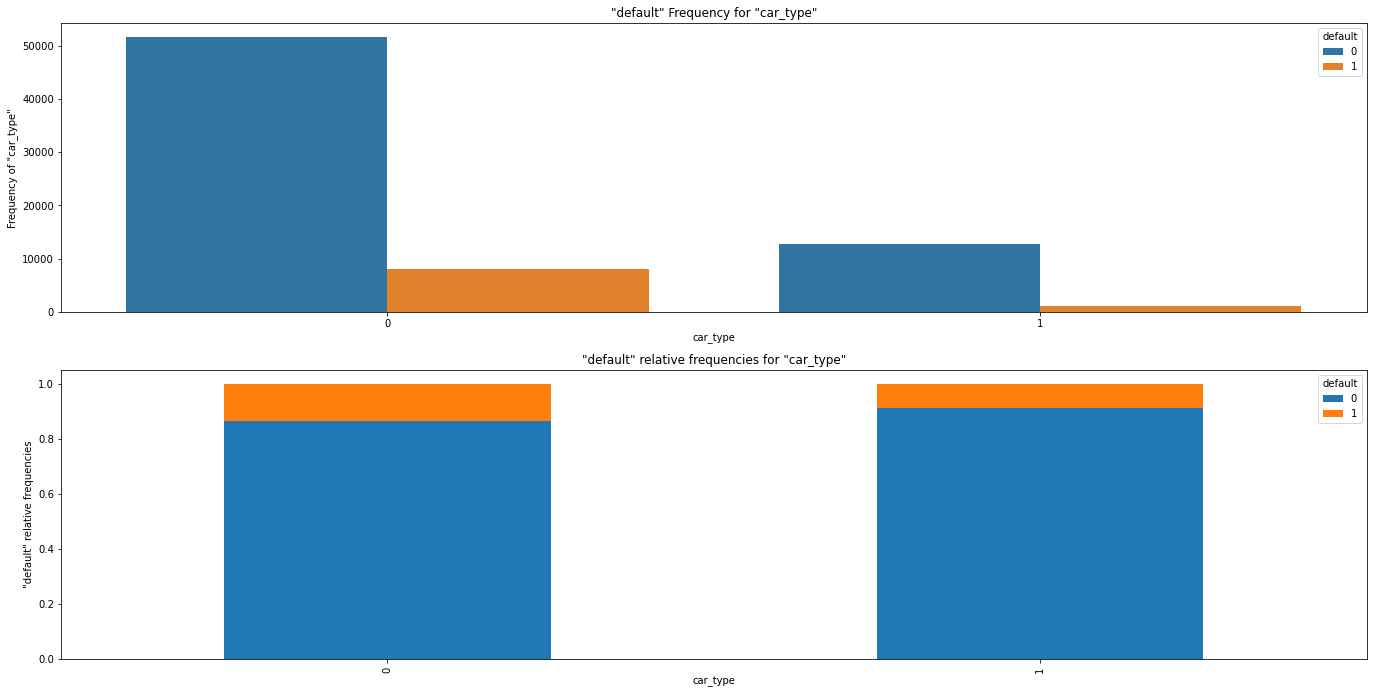

In [73]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "car_type",
    [
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 11.7)
)

У людей с иномарками относительная частота дефолтов меньше.

##### `foreign_passport`

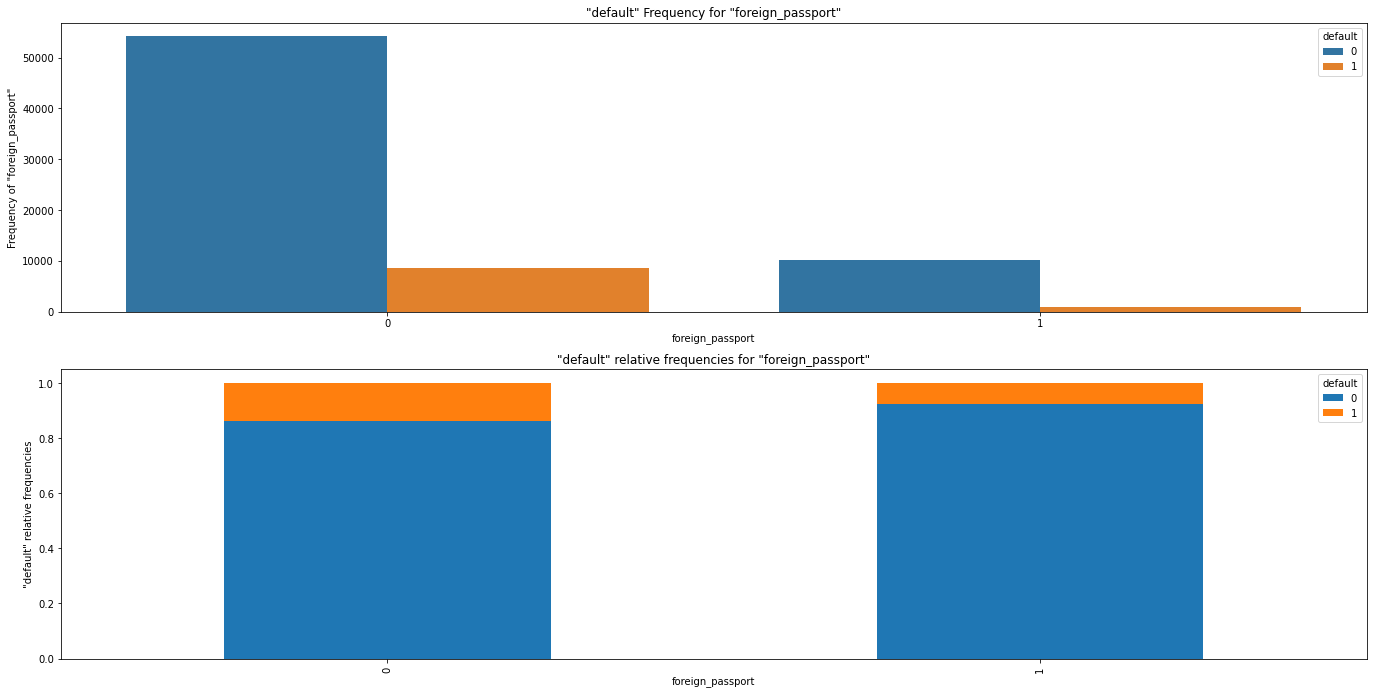

In [74]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "foreign_passport",
    [
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 11.7)
)

У людей с загранпаспортами относительная частота дефолтов меньше.

##### `sex_male`

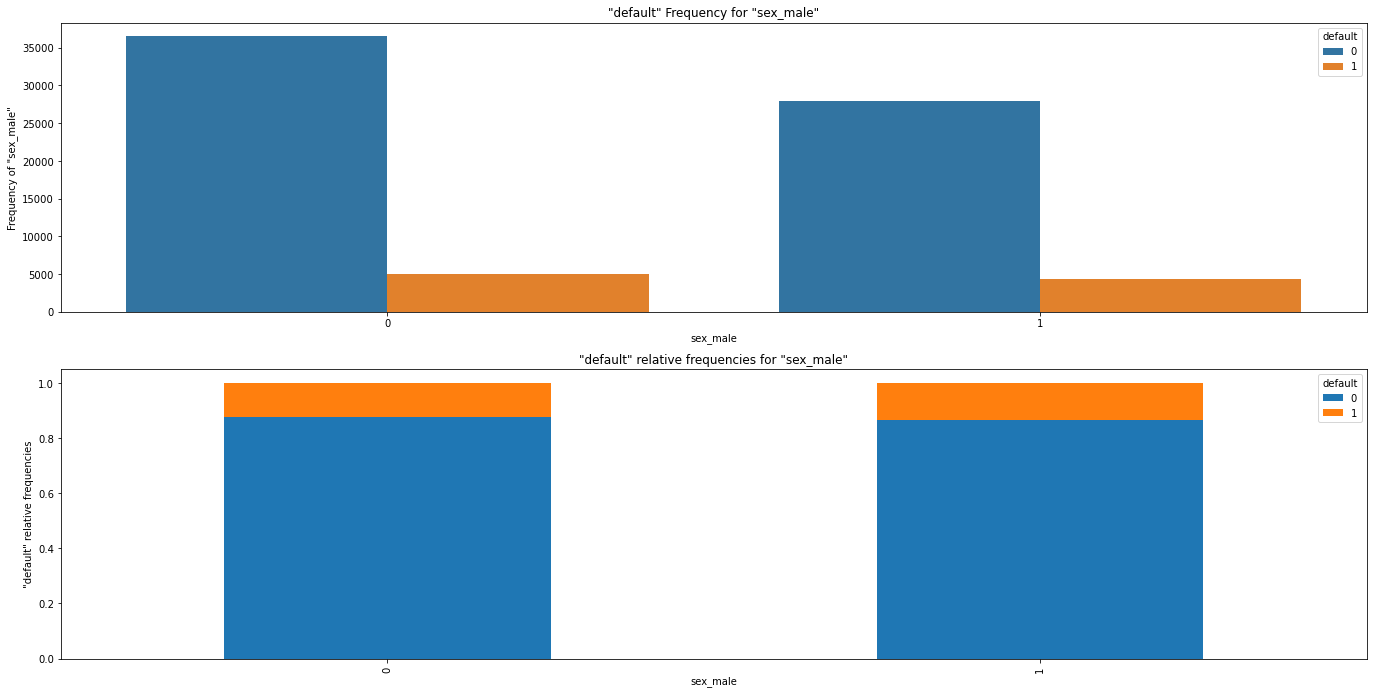

In [75]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "sex_male",
    [
        "class_count_histogram", "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 11.7)
)

У мужчин относителная частота дефолтов больше чем у женщин.<br />
Возможно это связано с б'ольшими рисками дел, под которые берутся кредиты.

#### Корреляции категориальных и бинарных переменных

Предположим, что числовые коды номинативных переменных тоже могут как-то коррелировать.

<AxesSubplot:>

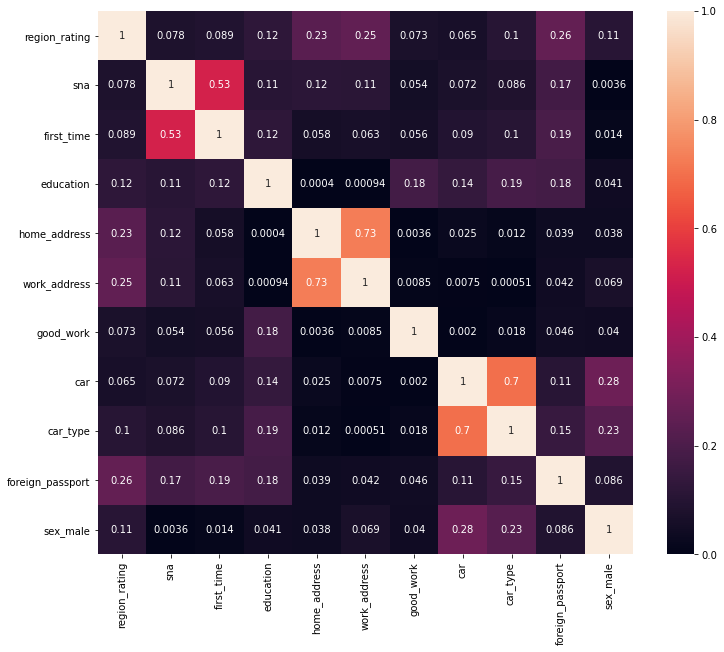

In [76]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    pre_data_no_dummies[pre_data_no_dummies["sample"] == 1][
        ordinal_columns+nominal_columns+binary_columns
    ].corr().abs(),
    annot=True, vmin=0, vmax=1, ax=ax
)

In [77]:
pre_data_no_dummies[pre_data_no_dummies["sample"] == 1][
    ordinal_columns+nominal_columns+binary_columns
].corr()

region_rating       sna  first_time  education  \
region_rating          1.000000 -0.078199    0.088777   0.121886   
sna                   -0.078199  1.000000   -0.525206  -0.106743   
first_time             0.088777 -0.525206    1.000000   0.123413   
education              0.121886 -0.106743    0.123413   1.000000   
home_address           0.233820  0.115196   -0.058476   0.000404   
work_address           0.253541  0.111114   -0.063202  -0.000940   
good_work              0.073041 -0.054041    0.055821   0.178148   
car                    0.064685 -0.072100    0.089959   0.137049   
car_type               0.104110 -0.085844    0.103973   0.185549   
foreign_passport       0.255456 -0.174298    0.194513   0.179608   
sex_male               0.107711 -0.003558    0.014126   0.040501   

                  home_address  work_address  good_work       car  car_type  \
region_rating         0.233820      0.253541   0.073041  0.064685  0.104110   
sna                   0.115196      0.111114  -0.054041 -0.072100 -0.085844   
first_time           -0.058476     -0.063202   0.055821  0.089959  0.103973   
education             0.000404     -0.000940   0.178148  0.137049  0.185549   
home_address          1.000000      0.728139  -0.003624 -0.025240 -0.012032   
work_address          0.728139      1.000000  -0.008535 -0.007523  0.000506   
good_work            -0.003624     -0.008535   1.000000  0.002027  0.017521   
car                  -0.025240     -0.007523   0.002027  1.000000  0.697939   
car_type             -0.012032      0.000506   0.017521  0.697939  1.000000   
foreign_passport      0.038658      0.041769   0.046361  0.107568  0.145807   
sex_male              0.037607      0.068967  -0.040247  0.279488  0.225578   

                  foreign_passport  sex_male  
region_rating             0.255456  0.107711  
sna                      -0.174298 -0.003558  
first_time                0.194513  0.014126  
education                 0.179608  0.040501  
home_address              0.038658  0.037607  
work_address              0.041769  0.068967  
good_work                 0.046361 -0.040247  
car                       0.107568  0.279488  
car_type                  0.145807  0.225578  
foreign_passport          1.000000  0.086326  
sex_male                  0.086326  1.000000

Сильнее всего коррелируют между собой:
- `home_address` - `work_address`;
- `car` - `car_type`;
- `sna` - `first_time`.

Есть и другие отличные от нуля, но заметно меньшие корреляции.
Например связь `region_rating` с `foreign_passport` и т.п.

**Возможные действия:**
- из двух признаков `home_address` и `work_address` оставить один признак;
- вместо двух признаков `car` и `car_type` ввести ординальную переменную для обозначения<br />
способа перемещения человека: `1` - без автомобиля, `2` - на отечественном автомобиле, `3` - на иномарке;
- попытаться оставить из двух признаков `sna` и `first_time` только один, например `sna`.

#### Значимость категориальных и бинарных переменных

<AxesSubplot:>

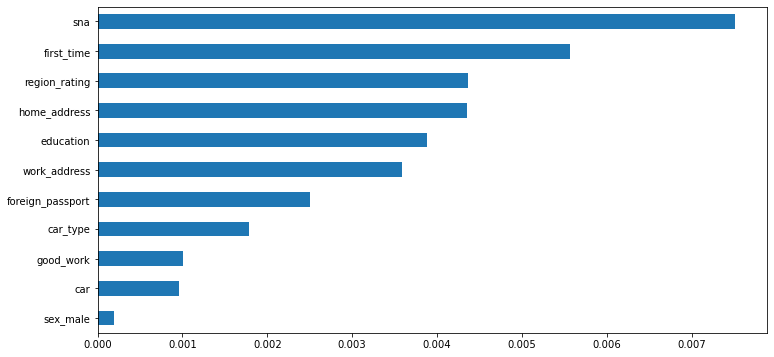

In [78]:
imp_cat = Series(
    mutual_info_classif(
            pre_data_no_dummies[pre_data_no_dummies["sample"] == 1][
                ordinal_columns+nominal_columns+binary_columns
            ],
            pre_data_no_dummies[pre_data_no_dummies["sample"] == 1]['default'],
            discrete_features =True
        ),
    index = ordinal_columns+nominal_columns+binary_columns
)
imp_cat.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(12, 6))
imp_cat.plot(kind = 'barh', ax=ax)

Самые значимые признаки:
- `sna`,
- `first_time`,
- `region_rating`,
- `home_address`,
- `education`

Другие признаки, такие как `work_address`, `foreign_passport` и т.п. менее значимы.

**Действия:**
- оставить оба признака `sna` и `first_time` несмотря на линейную корреляцию;
- из двух признаков `home_address` и `work_address` оставить только `home_address`;
- вместо двух признаков `car` и `car_type` ввести ординальную переменную для обозначения<br />
способа перемещения человека: `1` - без автомобиля, `2` - на отечественном автомобиле, `3` - на иномарке;
- в качестве последнего выбранного признака оставить `foreign_passport`.

#### Переменная даты заявки на кредит

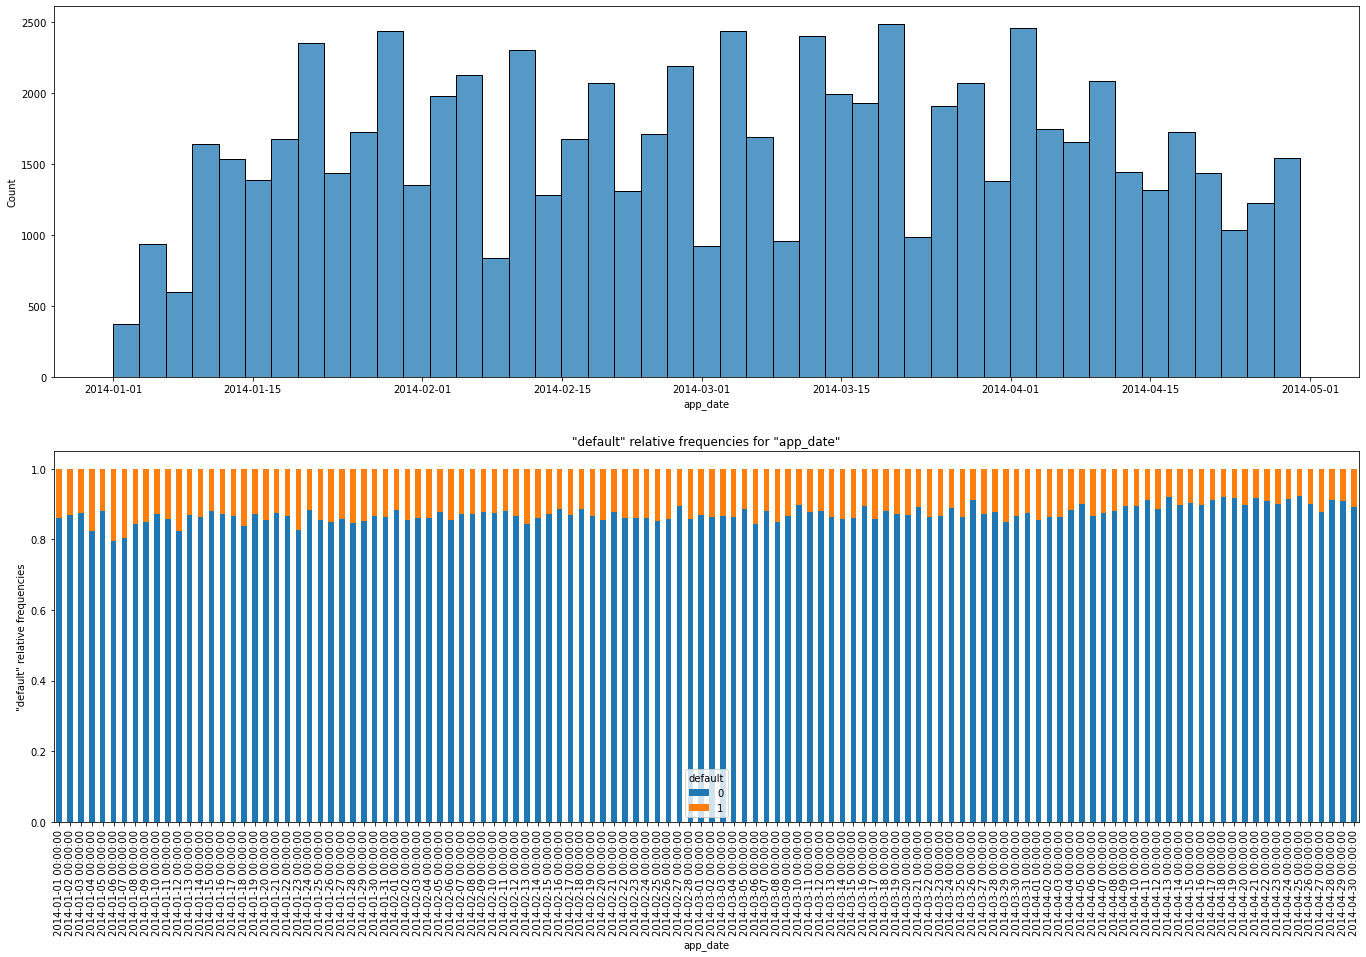

In [79]:
display_variable_info(
    pre_data[pre_data["sample"] == 1], "app_date",
    [
        "histogram",
        "class_percentstacked_histogram"
    ],
    target_column_name="default",
    calculate_outliers=False,
    figsize_inches=(23.4, 15)
)

Визуально видно две тенденции.

1. Число заявок на кредиты мало в начале года и немного снижается к концу апреля в данной выборке.
2. Относительная частота дефолтов по кредитам медленно снижается от начала 2014-го года к концу весны.

**Действия:**
- Ввести порядковый нмер дня от начала 2014-го года чтобы учесть заявки на<br />
кредиты и частоты дефолтов в зависимости от временно шкалы этого года.

## Feature Engineering, формирование итогового датасета

In [80]:
# Выбросы удаляем только из обучающей выборки.
train_dataset = pre_data[pre_data["sample"] == 1].copy()

# Над тестовой частью датасета проводим только логарифмирования и стандартизации.
test_dataset = pre_data[pre_data["sample"] == 0].copy()

### Числовые переменные

#### Удаление выбросов/логарифмирование

Делаем удаление выбросов и логарифмирование избирательно.
Выбросы удаляем только в тренировочном датасете.

In [81]:
# ====================
# score_bki
column_name = "score_bki"
print(f"{column_name}: train_dataset before: {train_dataset.shape[0]}")

outliers_info = outliers_dictionary["score_bki"]["outliers_info"]
train_dataset = train_dataset[
    (train_dataset["score_bki"] >= outliers_info["left_boundary"])&\
        (train_dataset["score_bki"] <= outliers_info["right_boundary"])
]

print(f"{column_name}: train_dataset after: {train_dataset.shape[0]}")
# ====================

# ====================
# decline_app_cnt
# nothing
# ====================

# ====================
# bki_request_cnt
column_name = "bki_request_cnt"
print(f"{column_name}: train_dataset before: {train_dataset.shape[0]}")

train_dataset[column_name] = np.log10(train_dataset[column_name] + 1)
test_dataset[column_name] = np.log10(test_dataset[column_name] + 1)

outliers_info = outliers_dictionary["bki_request_cnt"]["log_outliers_info"]
train_dataset = train_dataset[
    (train_dataset["bki_request_cnt"] >= outliers_info["left_boundary"])&\
        (train_dataset["bki_request_cnt"] <= outliers_info["right_boundary"])
]
print(f"{column_name}: train_dataset after: {train_dataset.shape[0]}")
# ====================

# ====================
# income
column_name = "income"
print(f"{column_name}: dataset before: {train_dataset.shape[0]}")

train_dataset[column_name] = np.log10(train_dataset[column_name])
test_dataset[column_name] = np.log10(test_dataset[column_name])

print(f"{column_name}: dataset after: {train_dataset.shape[0]}")
# ====================

score_bki: train_dataset before: 73799
score_bki: train_dataset after: 73448
bki_request_cnt: train_dataset before: 73448
bki_request_cnt: train_dataset after: 73442
income: dataset before: 73442
income: dataset after: 73442


### Категориальные и бинарные переменные

- бинарные переменные `car` и `car_type` преобразуем в новую ординальную переменную `transport_type` со значениями `1` - нет автомобиля, `2` - отечественный автомобиль, `3` - иномарка.

In [82]:
train_dataset["transport_type"] = 1 + train_dataset["car"] + train_dataset["car_type"]

In [83]:
train_dataset["transport_type"].value_counts(ascending=False)

1    49584
3    13942
2     9916
Name: transport_type, dtype: int64

In [84]:
test_dataset["transport_type"] = 1 + test_dataset["car"] + test_dataset["car_type"]

In [85]:
test_dataset["transport_type"].value_counts(ascending=False)

1    24458
3     7000
2     4891
Name: transport_type, dtype: int64

In [86]:
train_dataset = feature_transformer.move_columns_after_given_one(
    train_dataset, ["transport_type"], "car_type"
)
train_dataset.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  age  \
21996      33077  -2.207174                2         0.000000  4.255273   26   
32537      62812  -2.410540                0         0.301030  4.602060   25   
41045      49159  -1.697117                0         0.477121  4.204120   42   

       region_rating  sna  first_time  education   app_date  good_work  car  \
21996              4    1           3          3 2014-02-09          0    0   
32537              3    1           4          3 2014-03-12          0    1   
41045              4    1           4          4 2014-02-26          0    0   

       car_type  transport_type  foreign_passport  sex_male  home_address_1  \
21996         0               1                 0         0             1.0   
32537         0               2                 0         1             1.0   
41045         0               1                 0         0             0.0   

       home_address_2  home_address_3  work_address_1  work_address_2  \
21996             0.0             0.0             0.0             1.0   
32537             0.0             0.0             0.0             0.0   
41045             1.0             0.0             0.0             0.0   

       work_address_3  default  sample  
21996             0.0        0       1  
32537             1.0        0       1  
41045             1.0        0       1

In [87]:
test_dataset = feature_transformer.move_columns_after_given_one(
    test_dataset, ["transport_type"], "car_type"
)
test_dataset.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  age  \
108783      83318  -2.583476                0         0.000000  4.903090   37   
95664       27154  -1.596194                0         0.477121  4.477121   54   
81615       78397  -2.134132                0         0.000000  4.176091   33   

        region_rating  sna  first_time  education   app_date  good_work  car  \
108783              7    1           4          6 2014-03-31          1    0   
95664               4    1           4          2 2014-02-03          0    1   
81615               5    2           1          2 2014-03-26          0    0   

        car_type  transport_type  foreign_passport  sex_male  home_address_1  \
108783         0               1                 0         1             0.0   
95664          1               3                 0         1             1.0   
81615          0               1                 0         0             1.0   

        home_address_2  home_address_3  work_address_1  work_address_2  \
108783             1.0             0.0             0.0             0.0   
95664              0.0             0.0             0.0             1.0   
81615              0.0             0.0             1.0             0.0   

        work_address_3  default  sample  
108783             1.0       -1       0  
95664              0.0       -1       0  
81615              0.0       -1       0

### Переменная даты подачи заявки

- `app_date` преобразуем в новый признак порядкового номера дня в году `day_of_year`.

In [88]:
train_dataset["day_of_year"] = train_dataset["app_date"].dt.dayofyear
train_dataset = feature_transformer.move_columns_after_given_one(
    train_dataset, ["day_of_year"], "app_date"
)
train_dataset.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  age  \
72910       9861  -2.210370                0         0.845098  4.477121   40   
2532       26134  -1.243826                1         0.698970  4.477121   30   
18825      63164  -2.461963                3         0.301030  4.740363   55   

       region_rating  sna  first_time  education   app_date  day_of_year  \
72910              5    1           3          2 2014-01-17           17   
2532               6    3           3          4 2014-02-02           33   
18825              7    3           2          2 2014-03-12           71   

       good_work  car  car_type  transport_type  foreign_passport  sex_male  \
72910          0    0         0               1                 0         1   
2532           0    0         0               1                 0         1   
18825          0    1         1               3                 1         1   

       home_address_1  home_address_2  home_address_3  work_address_1  \
72910             1.0             0.0             0.0             0.0   
2532              0.0             1.0             0.0             0.0   
18825             0.0             1.0             0.0             0.0   

       work_address_2  work_address_3  default  sample  
72910             1.0             0.0        0       1  
2532              0.0             1.0        1       1  
18825             0.0             1.0        0       1

In [89]:
test_dataset["day_of_year"] = test_dataset["app_date"].dt.dayofyear
test_dataset = feature_transformer.move_columns_after_given_one(
    test_dataset, ["day_of_year"], "app_date"
)
test_dataset.sample(3)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  age  \
85673       37499  -1.998685                0          0.30103  4.397940   40   
109785      88591  -1.830731                0          0.00000  4.778151   37   
81372         474  -0.183207                0          0.00000  4.477121   45   

        region_rating  sna  first_time  education   app_date  day_of_year  \
85673               3    4           3          2 2014-02-13           44   
109785              7    1           3          2 2014-04-04           94   
81372               4    1           3          2 2014-01-03            3   

        good_work  car  car_type  transport_type  foreign_passport  sex_male  \
85673           0    0         0               1                 0         0   
109785          0    1         0               2                 0         1   
81372           0    1         0               2                 0         1   

        home_address_1  home_address_2  home_address_3  work_address_1  \
85673              0.0             1.0             0.0             0.0   
109785             0.0             1.0             0.0             0.0   
81372              1.0             0.0             0.0             0.0   

        work_address_2  work_address_3  default  sample  
85673              0.0             1.0       -1       0  
109785             0.0             1.0       -1       0  
81372              0.0             1.0       -1       0

### Общий датасет
Объединим ещё раз датасеты для обучения и теста, чтобы иметь один объект.

In [90]:
model_dataset = pd.concat([train_dataset, test_dataset], ignore_index=True)
model_dataset.sample(5)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  age  \
57828      75024  -2.552016                0          0.00000  4.021189   64   
22359      39483  -2.017341                0          0.30103  4.176091   32   
60805      28901  -2.504148                0          0.00000  4.778151   48   
78221     105357  -1.563985                1          0.00000  4.602060   45   
252        33883  -2.378426                0          0.30103  4.954243   34   

       region_rating  sna  first_time  education   app_date  day_of_year  \
57828              5    4           1          2 2014-03-22           81   
22359              5    4           1          3 2014-02-15           46   
60805              4    1           4          4 2014-02-05           36   
78221              7    1           4          2 2014-04-24          114   
252                6    1           4          4 2014-02-10           41   

       good_work  car  car_type  transport_type  foreign_passport  sex_male  \
57828          0    0         0               1                 0         1   
22359          0    0         0               1                 0         0   
60805          0    0         0               1                 0         0   
78221          0    1         0               2                 1         1   
252            1    1         1               3                 1         0   

       home_address_1  home_address_2  home_address_3  work_address_1  \
57828             0.0             1.0             0.0             0.0   
22359             0.0             1.0             0.0             0.0   
60805             1.0             0.0             0.0             1.0   
78221             0.0             1.0             0.0             0.0   
252               1.0             0.0             0.0             0.0   

       work_address_2  work_address_3  default  sample  
57828             0.0             1.0        0       1  
22359             0.0             1.0        0       1  
60805             0.0             0.0        0       1  
78221             0.0             1.0       -1       0  
252               0.0             1.0        0       1

### Выбор переменных

In [91]:
model_variables = numerical_columns + ["day_of_year"] \
    + ordinal_columns + ["transport_type"] \
        + list(filter(lambda c: c not in ["car", "car_type"], binary_columns)) \
            + nominal_columns_dummy \
                + ["default", "sample"]

model_variables

['score_bki',
 'decline_app_cnt',
 'bki_request_cnt',
 'income',
 'age',
 'day_of_year',
 'region_rating',
 'sna',
 'first_time',
 'education',
 'transport_type',
 'good_work',
 'foreign_passport',
 'sex_male',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'default',
 'sample']

In [92]:
model_dataset.isna().sum() 

client_id           0
score_bki           0
decline_app_cnt     0
bki_request_cnt     0
income              0
age                 0
region_rating       0
sna                 0
first_time          0
education           0
app_date            0
day_of_year         0
good_work           0
car                 0
car_type            0
transport_type      0
foreign_passport    0
sex_male            0
home_address_1      0
home_address_2      0
home_address_3      0
work_address_1      0
work_address_2      0
work_address_3      0
default             0
sample              0
dtype: int64

### Новое формирование обучающей выборки и тестовой выборки.

Назовём выборку с колонкой `sample`, равной единице "educational",<br />
а выборку с колонкой `sample`, равной нулю, "test".
Таким оразом получим разбиение всех данных модели:<br />

|-----------------`educational`-----------------|---`test`---|<br />
|----------`training`-----------|---`validation`---|---`test`---|

Стандартизацию выборок
- `trainig`,
- `validation`,
- `test`

с помощью `StandardScaler` будем проводить на основе параметров выборки `training`.

In [93]:
# ==============================
# 1. Переменные
sample_variable = "sample"
target_variable = "default"
X_variables = list(filter(lambda c: c not in [target_variable, sample_variable], model_variables))
# ==============================

# ==============================
# 2. Разбиение выборки educational на обучающую и валидационную
educational_dataset = model_dataset[model_dataset[sample_variable] == 1]
educational_dataset.drop([sample_variable], axis=1, inplace=True)
# --------------------
X_educational = educational_dataset[X_variables]
Y_educational = educational_dataset[target_variable]
X_training, X_validation, Y_training, Y_validation = \
    train_test_split(X_educational, Y_educational, test_size=0.2, random_state=42)
# --------------------
# ==============================

# ==============================
# 3. Формирование данных тестовой выборки
test_dataset = model_dataset[model_dataset["sample"] == 0]
X_test = test_dataset.drop(["default", "sample"], axis=1)
# ==============================

print("==============================")
print(f"Independent variables: {X_variables}")
print(f"Target variable: {target_variable}")
print("==============================")
print(f"model_dataset shape: {model_dataset.shape}")
print("--------------------")
print(f"educational_dataset shape: {educational_dataset.shape}")
print("--------------------")
print(f"X_educational shape: {X_educational.shape}")
print(f"Y_educational shape: {Y_educational.shape}")
print("--------------------")
print(f"X_training shape: {X_training.shape}")
print(f"Y_training shape: {Y_training.shape}")
print("----------")
print(f"X_validation shape: {X_validation.shape}")
print(f"Y_validation shape: {Y_validation.shape}")
print("--------------------")
print(f"X_test shape: {X_test.shape}")
print("==============================")

Independent variables: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'age', 'day_of_year', 'region_rating', 'sna', 'first_time', 'education', 'transport_type', 'good_work', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3']
Target variable: default
model_dataset shape: (109791, 26)
--------------------
educational_dataset shape: (73442, 25)
--------------------
X_educational shape: (73442, 20)
Y_educational shape: (73442,)
--------------------
X_training shape: (58753, 20)
Y_training shape: (58753,)
----------
X_validation shape: (14689, 20)
Y_validation shape: (14689,)
--------------------
X_test shape: (36349, 24)


### Стандартизация числовых переменных.
Стандартизацию выборок
- `trainig`,
- `validation`,
- `test`

с помощью `StandardScaler` будем проводить на основе параметров выборки `training`.

In [94]:
numerical_columns

['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'age']

In [95]:
numerical_features_scaler = StandardScaler()
fitted_numerical_features_scaler = \
    numerical_features_scaler.fit(X_training[numerical_columns])

X_training[numerical_columns] = \
    fitted_numerical_features_scaler.transform(X_training[numerical_columns])

X_validation[numerical_columns] = \
    fitted_numerical_features_scaler.transform(X_validation[numerical_columns])

X_test[numerical_columns] = \
    fitted_numerical_features_scaler.transform(X_test[numerical_columns])

In [96]:
numerical_features_scaler.n_samples_seen_

58753

In [97]:
X_training.sample(5)

score_bki  decline_app_cnt  bki_request_cnt    income       age  \
49733  -0.713737        -0.342008         1.828473 -1.043902 -0.545101   
46069  -0.105446        -0.342008        -0.281296 -0.951521  2.230210   
68820  -0.712732        -0.342008         0.773589 -0.051722  0.669098   
55268   0.572743        -0.342008        -1.336180 -1.043902 -1.325657   
19646  -1.632475        -0.342008        -1.336180 -2.094516  2.143482   

       day_of_year  region_rating  sna  first_time  education  transport_type  \
49733           26              4    3           3          2               1   
46069           79              5    1           3          2               1   
68820           34              4    1           3          4               1   
55268          108              4    4           1          2               2   
19646           13              3    4           1          2               1   

       good_work  foreign_passport  sex_male  home_address_1  home_address_2  \
49733          0                 0         0             1.0             0.0   
46069          0                 0         0             0.0             1.0   
68820          0                 0         1             0.0             1.0   
55268          0                 0         0             0.0             1.0   
19646          0                 0         0             1.0             0.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
49733             0.0             0.0             1.0             0.0  
46069             0.0             0.0             0.0             1.0  
68820             0.0             0.0             0.0             1.0  
55268             0.0             0.0             0.0             1.0  
19646             0.0             0.0             1.0             0.0

In [98]:
X_validation.sample(5)

score_bki  decline_app_cnt  bki_request_cnt    income       age  \
24733   1.878349         0.906687        -1.336180 -0.632110  0.669098   
59966  -2.335472        -0.342008         0.335772 -0.202536 -0.371644   
34102  -0.278927        -0.342008        -1.336180 -0.782925  0.322184   
15885  -0.576804        -0.342008         0.335772  0.360070 -0.718558   
45261  -0.808433        -0.342008         0.335772 -0.051722  2.056753   

       day_of_year  region_rating  sna  first_time  education  transport_type  \
24733           62              5    4           1          4               1   
59966           62              5    1           4          4               1   
34102           22              5    1           3          2               1   
15885           14              7    1           4          4               1   
45261          115              4    1           4          2               1   

       good_work  foreign_passport  sex_male  home_address_1  home_address_2  \
24733          0                 0         1             1.0             0.0   
59966          1                 0         1             1.0             0.0   
34102          0                 0         0             0.0             1.0   
15885          0                 0         1             0.0             1.0   
45261          1                 1         1             1.0             0.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
24733             0.0             0.0             1.0             0.0  
59966             0.0             0.0             1.0             0.0  
34102             0.0             0.0             0.0             1.0  
15885             0.0             0.0             0.0             1.0  
45261             0.0             1.0             0.0             0.0

In [99]:
X_test.sample(5)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  \
82179      99401   0.900511        -0.342008        -1.336180  0.360070   
80156      36122  -0.650589        -0.342008         0.335772  0.168932   
96239      80785  -1.141000        -0.342008         0.335772 -0.051722   
76082      26203  -1.303053        -0.342008        -0.281296 -1.624290   
75412      32237   0.218029        -0.342008         0.335772 -1.043902   

            age  region_rating  sna  first_time  education   app_date  \
82179 -0.805286              5    1           3          4 2014-04-16   
80156 -1.499114              7    1           4          3 2014-02-12   
96239 -0.111458              7    1           4          2 2014-03-28   
76082  2.403667              5    3           1          2 2014-02-02   
75412  0.582369              4    1           4          2 2014-02-08   

       day_of_year  good_work  car  car_type  transport_type  \
82179          106          0    1         1               3   
80156           43          0    0         0               1   
96239           87          0    0         0               1   
76082           33          0    1         0               2   
75412           39          0    0         0               1   

       foreign_passport  sex_male  home_address_1  home_address_2  \
82179                 0         1             1.0             0.0   
80156                 0         0             0.0             1.0   
96239                 0         1             0.0             1.0   
76082                 0         0             1.0             0.0   
75412                 0         0             1.0             0.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
82179             0.0             0.0             1.0             0.0  
80156             0.0             0.0             0.0             1.0  
96239             0.0             0.0             0.0             1.0  
76082             0.0             1.0             0.0             0.0  
75412             0.0             0.0             1.0             0.0

## Модель 1

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
print(f"model_variables_X[{len(X_variables)}]: {X_variables}")

X_training_model = X_training
Y_training_model = Y_training
X_validation_model = X_validation
Y_validation_model = Y_validation

model = LogisticRegression(random_state=42)
fitted_model = model.fit(X_training_model, Y_training_model)

Y_validation_predicted = fitted_model.predict(X_validation_model)
Y_validation_predicted_proba = fitted_model.predict_proba(X_validation_model)

roc_auc_score_value = roc_auc_score(Y_validation_model, Y_validation_predicted_proba[:, 1])
print(f"fitted_model.coef_: {fitted_model.coef_}")
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")
print(f"confusion_matrix:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0]))}")
print(f"confusion_matrix normalized:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='pred'))}")
print(f"accuracy_score: {accuracy_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"precision_score: {precision_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"recall_score: {recall_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"f1_score: {f1_score(Y_validation_model, Y_validation_predicted):0.3f}")

model_variables_X[20]: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'age', 'day_of_year', 'region_rating', 'sna', 'first_time', 'education', 'transport_type', 'good_work', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3']
fitted_model.coef_: [[ 0.46810263  0.10963113  0.1732063  -0.02731221 -0.06048921 -0.00423705
  -0.25796615  0.11457114 -0.11295543 -0.18705318 -0.14116552 -0.22816344
  -0.24401385  0.28681226 -0.25767728  0.30689317 -0.11913063 -0.26088551
   0.03133957  0.1596312 ]]
Logistic Regression ROC-AUC score: 0.733
confusion_matrix:
array([[   49,  1877],
       [   49, 12714]])
confusion_matrix normalized:
array([[0.5       , 0.12864094],
       [0.5       , 0.87135906]])
accuracy_score: 0.869
precision_score: 0.500
recall_score: 0.025
f1_score: 0.048


## Модель 2

In [101]:
model_variables_X = list(filter(
    lambda var: ("work_address" not in var) \
        and (var not in ["income", "age", "transport_type", "foreign_passport"]),
    X_variables
))
print(f"model_variables_X[{len(model_variables_X)}]: {model_variables_X}")

X_training_model = X_training[model_variables_X]
Y_training_model = Y_training
X_validation_model = X_validation[model_variables_X]
Y_validation_model = Y_validation

model = LogisticRegression(random_state=42)
fitted_model = model.fit(X_training_model, Y_training_model)

Y_validation_predicted = fitted_model.predict(X_validation_model)
Y_validation_predicted_proba = fitted_model.predict_proba(X_validation_model)

roc_auc_score_value = roc_auc_score(Y_validation_model, Y_validation_predicted_proba[:, 1])
print(f"fitted_model.coef_: {fitted_model.coef_}")
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")
print(f"confusion_matrix:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0]))}")
print(f"confusion_matrix normalized:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='pred'))}")
print(f"accuracy_score: {accuracy_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"precision_score: {precision_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"recall_score: {recall_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"f1_score: {f1_score(Y_validation_model, Y_validation_predicted):0.3f}")

model_variables_X[13]: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'day_of_year', 'region_rating', 'sna', 'first_time', 'education', 'good_work', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3']
fitted_model.coef_: [[ 0.47203816  0.11820881  0.1709449  -0.0039991  -0.26731339  0.12897439
  -0.13424442 -0.21036639 -0.22745698  0.25077348 -0.35217453  0.37363316
  -0.10318834]]
Logistic Regression ROC-AUC score: 0.733
confusion_matrix:
array([[   53,  1873],
       [   48, 12715]])
confusion_matrix normalized:
array([[0.52475248, 0.1283932 ],
       [0.47524752, 0.8716068 ]])
accuracy_score: 0.869
precision_score: 0.525
recall_score: 0.028
f1_score: 0.052


Удаление переменных `work_address_*`, `income`, `age`, `transport_type` и `foreign_passport`<br />
не измемнило значение метрии ROC-AUC score.

Если удалять только переменные `work_address_*` и `income`, то значение метрики будет `0.734`,<br />
но это несущественное улучшение по сравнению с возможностью уменьшить<br />
размерность пространства переменных с `20`-ти до `13`-ти.

Удалённые признаки в целом соответствуют списку признаков,<br />
которые являются либо коррелирущими признаками (`work_address` и `home_address`),<br />

Попытка удалить другие переменные ухудшает метрику уже во втором знаке после запятой.

## Модель 3

Преобразование ординальных переменных в dummy переменные с помощью One-Hot Encoding.

In [102]:
ordinal_columns + ["transport_type"]

['region_rating', 'sna', 'first_time', 'education', 'transport_type']

In [103]:
X_validation.columns

Index(['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'age',
       'day_of_year', 'region_rating', 'sna', 'first_time', 'education',
       'transport_type', 'good_work', 'foreign_passport', 'sex_male',
       'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1',
       'work_address_2', 'work_address_3'],
      dtype='object')

In [104]:
X_training_model = X_training.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_training_model[ordinal_column], prefix=ordinal_column)
    X_training_model = pd.concat([X_training_model, dummies], axis=1)
    X_training_model.drop([ordinal_column], axis=1, inplace=True)

X_validation_model = X_validation.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_validation_model[ordinal_column], prefix=ordinal_column)
    X_validation_model = pd.concat([X_validation_model, dummies], axis=1)
    X_validation_model.drop([ordinal_column], axis=1, inplace=True)

# ========================================
model_variables_X = X_training_model.columns
model_variables_X = list(filter(
    lambda var: ("work_address" not in var) \
        and (var not in ["income"]),
    model_variables_X
))
print(f"model_variables_X[{len(model_variables_X)}]: {model_variables_X}")
# ========================================
X_training_model = X_training_model[model_variables_X]
Y_training_model = Y_training
X_validation_model = X_validation_model[model_variables_X]
Y_validation_model = Y_validation

model = LogisticRegression(random_state=42)
fitted_model = model.fit(X_training_model, Y_training_model)

Y_validation_predicted = fitted_model.predict(X_validation_model)
Y_validation_predicted_proba = fitted_model.predict_proba(X_validation_model)

roc_auc_score_value = roc_auc_score(Y_validation_model, Y_validation_predicted_proba[:, 1])
print(f"fitted_model.coef_: {fitted_model.coef_}")
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")
print(f"confusion_matrix:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0]))}")
print(f"confusion_matrix normalized:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='pred'))}")
print(f"accuracy_score: {accuracy_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"precision_score: {precision_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"recall_score: {recall_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"f1_score: {f1_score(Y_validation_model, Y_validation_predicted):0.3f}")

model_variables_X[35]: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'age', 'day_of_year', 'good_work', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'region_rating_1', 'region_rating_2', 'region_rating_3', 'region_rating_4', 'region_rating_5', 'region_rating_6', 'region_rating_7', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'transport_type_1', 'transport_type_2', 'transport_type_3']
fitted_model.coef_: [[ 0.4707507   0.11124879  0.17279372 -0.04646554 -0.00420434 -0.22853597
  -0.29595602  0.29283526 -0.66013035  0.08074159 -0.19523867  0.04321855
   0.03419947  0.32753164  0.05149016 -0.04885609 -0.40511861 -0.77709254
  -0.42129174 -0.16556399 -0.17917221 -0.00859948 -0.10844415 -0.03453343
  -0.23991814 -0.39173171 -0.02249576 -0.02407835 -0.16064654 -0.37819286
  -0.16232813 -0.02688579 -0.12

In [105]:
# tn, fp, fn, tp = confusion_matrix(Y_validation_model, Y_validation_predicted).ravel()
# (tn, fp, fn, tp)

Всё ещё очень низкое значение True Positive

## Промежуточные выводы

Различные сочетания признаков не смогли улучшить вид матрицы ошибок,<br />
нормализованной по столбцам (относительно предсказанных значений).<br />

`sklearn` выдаёт её с использованными параметрами в следующей форме:<br />

||Predicted|Label|
|---|---|---|---|
|||1|0|
|Actual|1|TP|FN|
|Label|0|FP|TN|

(см. [Understanding the Confusion Matrix from Scikit learn](https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79))


Доли истинно положительных результатов и ложно положительных результатов очень малы.<br />
То есть модель считает примерно в равной степени,<br />
что истинно будет дефолт и ложно, что что он тоже будет.

Доля ложно отрицательных результатов довольно существенна и составляет примерно 12 процентов.<br />
То есть в 12 процентах случаев, когда модель посчитала, что кредит вернут, его не вернули<br />
и в реальности произошёл дефолт.

Абсолютное количество True Positive дефолтов очень маленькое. Перекос в сторону True Negative и в сторону False Negative. Такая модель будет часто выдавать невозвращаемые кредиты.
Проблему также отражают метрики precision (практически 0.5) и полноты recall (0.03).

Необходимо попытаться оптимизировать модель.

## Выбор параметров и oversampling

Поскольку мы всё же не знаем реальных количественных "расстояний" между разными значениями ординальных переменных, то стоит остановиться на Модели №3 и полностью перейти на категориальные переменные.

Кроме этого стоит сделать oversampling минорного класса дефолтных кредитов для улучшения результатов обучения. Oversampling делается только на тренировочной выборке, чтобы не допустить утечки информации из валидационной выборки. Используется один из методов SMOTE - SVMSMOTE,
в котором помимо основного параметра поиска k лижайших соседий для обоих классов
используется дополнительный параметр для количества соседей из класса-меньшиства,
который больше основного.

[The Right Way to Oversample in Predictive Modeling](https://beckernick.github.io/oversampling-modeling/)

## Поиск гиперпараметров, улучшающих работу модели

В качестве метрики для поиска гиперпараметров выбираем **`roc_auc_score`** **для несбалансированной** через oversamplig тренировочной выборки для поиска гиперпараметров и **`f1_score`** после для поиска баланса между precision и recall для **сбалансированной** через oversampling выборки.

Нам желательно максимизировать количество истинно положительных результатов и сбалансировать количество ложных выдач кредитов, приносящих убытки, но с другой стороны ложно не недодавать кредитов, чтобы не упустить прибыль.

### Несбалансированная модель без oversampling и с `roc_auc_score`

Решатели `lbfgs` и `saga` не включены из-за экономии машинного времени и по факту они не выигрывали. Хотя возможно для дальшейших улучшений стоит рассмотреть комбинацию `l1` и `l2` penalties для `saga`<br />(полученные выигрышные значения `l1_ratio` - ~`0.05`, ~`0.07`).

Увеличение числа итераций и уменьшение tol не сильно улучшает выбранную метрику.<br />
Видимо надо будет дальше искать качественно другие способы предварительной работы с датасетом.

In [106]:
X_training_model = X_training.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_training_model[ordinal_column], prefix=ordinal_column)
    X_training_model = pd.concat([X_training_model, dummies], axis=1)
    X_training_model.drop([ordinal_column], axis=1, inplace=True)

X_validation_model = X_validation.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_validation_model[ordinal_column], prefix=ordinal_column)
    X_validation_model = pd.concat([X_validation_model, dummies], axis=1)
    X_validation_model.drop([ordinal_column], axis=1, inplace=True)

# ========================================
model_variables_X = X_training_model.columns
model_variables_X = list(filter(
    lambda var: ("work_address" not in var) \
        and (var not in ["income"]),
    model_variables_X
))
print(f"model_variables_X[{len(model_variables_X)}]: {model_variables_X}")
# ========================================
X_training_model = X_training_model[model_variables_X]
Y_training_model = Y_training

X_validation_model = X_validation_model[model_variables_X]
Y_validation_model = Y_validation

print(f"X_training_models: {X_training_model.shape}")

model_variables_X[35]: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'age', 'day_of_year', 'good_work', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'region_rating_1', 'region_rating_2', 'region_rating_3', 'region_rating_4', 'region_rating_5', 'region_rating_6', 'region_rating_7', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'transport_type_1', 'transport_type_2', 'transport_type_3']
X_training_models: (58753, 35)


In [107]:
hyperparameter_grid = [
    {
        'C': np.arange(0.05, 0.3, 0.05),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': ['balanced'],
        'multi_class': ['ovr'],
        'max_iter': [100],
        'tol': [1e-4]
    },
    {
        'C': np.arange(0.05, 0.3, 0.05),
        'penalty': ['l2'],
        'solver': ['newton-cg', 'sag'],
        'class_weight': ['balanced'],
        'multi_class': ['ovr'],
        'max_iter': [100],
        'tol': [1e-4]
    },
    # {
    #     'C': np.arange(0.1, 0.3, 0.05),
    #     'penalty': ['l1', 'l2', 'elasticnet'],
    #     'l1_ratio': [0.05, 0.07, 0.1],
    #     'solver': ['saga'],
    #     'class_weight': ['balanced'],
    #     'multi_class': ['ovr'],
    #     'max_iter': [100],
    #     'tol': [1e-4]
    # }
]

model = LogisticRegression(random_state=42)
fitted_model = model.fit(X_training_model, Y_training_model)
# ========================================
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

scoring = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)
clf = GridSearchCV(model, hyperparameter_grid, scoring=scoring, cv=cv, n_jobs=4, verbose=10)

best_model = clf.fit(X_training_model, Y_training_model)
# ========================================
# View best hyperparameters
print(f"Best parameters:\n{pprint.pformat(best_model.best_estimator_.get_params())}")
best_parameters = best_model.best_estimator_.get_params()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:
{'C': 0.05,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [108]:
model = LogisticRegression(
    C=best_parameters["C"],
    penalty=best_parameters["penalty"],
    solver=best_parameters["solver"],
    class_weight='balanced',
    multi_class='ovr',
    max_iter=best_parameters["max_iter"],
    tol=best_parameters["tol"],
    random_state=42,
    n_jobs=4
)
fitted_model = model.fit(X_training_model, Y_training_model)

Y_validation_predicted = fitted_model.predict(X_validation_model)
Y_validation_predicted_proba = fitted_model.predict_proba(X_validation_model)

roc_auc_score_value = roc_auc_score(Y_validation_model, Y_validation_predicted_proba[:, 1])
print(f"fitted_model.coef_: {fitted_model.coef_}")
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")
print(f"accuracy_score: {accuracy_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"precision_score: {precision_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"recall_score: {recall_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"f1_score: {f1_score(Y_validation_model, Y_validation_predicted):0.3f}")
print("==========")
print(f"confusion_matrix:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0]))}")
print(f"confusion_matrix normalized 'pred':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='pred'))}")
print(f"confusion_matrix normalized 'true':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='true'))}")
print(f"confusion_matrix normalized 'all':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='all'))}")

fitted_model.coef_: [[ 0.48953986  0.13372162  0.1815856  -0.04075402 -0.0041285  -0.21709461
  -0.24107985  0.31620226 -0.31663804  0.40857133 -0.16826226  0.47113215
   0.33791845  0.34464686  0.05756203 -0.04986015 -0.46528114 -0.77244716
  -0.24152362  0.02408382 -0.05286111  0.19397194  0.07229634  0.15861478
  -0.06013369 -0.24710639  0.06553613  0.29120658  0.15216407 -0.11083371
  -0.27134403 -0.20305801  0.10496359  0.04998632 -0.23127887]]
Logistic Regression ROC-AUC score: 0.736
accuracy_score: 0.672
precision_score: 0.235
recall_score: 0.669
f1_score: 0.348
confusion_matrix:
array([[1289,  637],
       [4186, 8577]])
confusion_matrix normalized 'pred':
array([[0.23543379, 0.06913393],
       [0.76456621, 0.93086607]])
confusion_matrix normalized 'true':
array([[0.66926272, 0.33073728],
       [0.32797932, 0.67202068]])
confusion_matrix normalized 'all':
array([[0.08775274, 0.04336578],
       [0.28497515, 0.58390632]])


Стоит также построить PRC кривую.
Это позволит взглянуть на работу модели в большей степени с точки зрения фактических данных.

In [109]:
precision, recall, thresholds = \
    precision_recall_curve(Y_validation_model, Y_validation_predicted)
print(f"PRC - Precision: {precision}")
print(f"PRC - Recall: {recall}")
print(f"PRC - Thresholds: {thresholds}")

PRC - Precision: [0.13111852 0.23543379 1.        ]
PRC - Recall: [1.         0.66926272 0.        ]
PRC - Thresholds: [0 1]


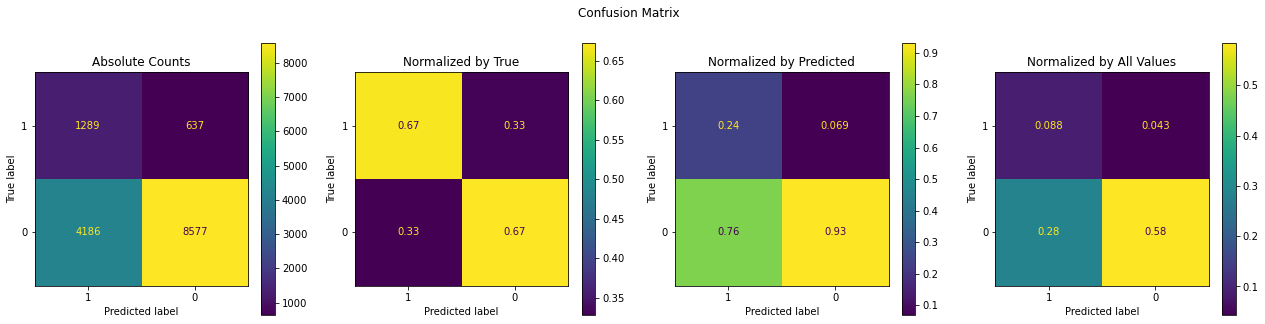

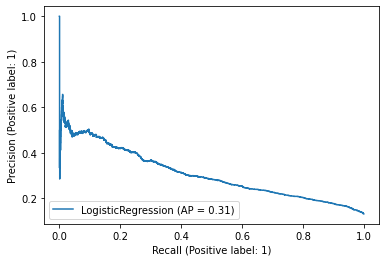

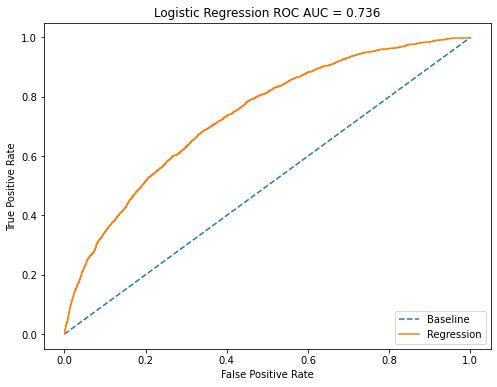

In [110]:
figure, axes = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches((22, 5))
figure.suptitle("Confusion Matrix")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize=None, ax=axes[0])
disp.ax_.set_title("Absolute Counts")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='true', ax=axes[1])
disp.ax_.set_title("Normalized by True")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='pred', ax=axes[2])
disp.ax_.set_title("Normalized by Predicted")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='all', ax=axes[3])
disp.ax_.set_title("Normalized by All Values")
plt.show()
# ==========
plot_precision_recall_curve(fitted_model, X_validation_model, Y_validation_model)
# ==========
fpr, tpr, threshold = roc_curve(Y_validation_model, Y_validation_predicted_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_score_value)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Сбалансированная модель с oversampling и `f1_score`

Решатели `lbfgs` и `saga` не включены из-за экономии машинного времени и по факту они не выигрывали. Хотя возможно для дальшейших улучшений стоит рассмотреть комбинацию `l1` и `l2` penalties для `saga`<br />(полученные выигрышные значения `l1_ratio` - ~`0.05`, ~`0.07`).

Увеличение числа итераций и уменьшение tol не сильно улучшает выбранную метрику.<br />
Видимо надо будет дальше искать качественно другие способы предварительной работы с датасетом.

In [111]:
X_training_model = X_training.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_training_model[ordinal_column], prefix=ordinal_column)
    X_training_model = pd.concat([X_training_model, dummies], axis=1)
    X_training_model.drop([ordinal_column], axis=1, inplace=True)

X_validation_model = X_validation.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_validation_model[ordinal_column], prefix=ordinal_column)
    X_validation_model = pd.concat([X_validation_model, dummies], axis=1)
    X_validation_model.drop([ordinal_column], axis=1, inplace=True)

# ========================================
model_variables_X = X_training_model.columns
model_variables_X = list(filter(
    lambda var: ("work_address" not in var) \
        and (var not in ["income"]),
    model_variables_X
))
print(f"model_variables_X[{len(model_variables_X)}]: {model_variables_X}")
# ========================================
X_training_model = X_training_model[model_variables_X]
Y_training_model = Y_training

X_validation_model = X_validation_model[model_variables_X]
Y_validation_model = Y_validation

print(f"X_training_models: {X_training_model.shape}")
sm = SVMSMOTE(
    sampling_strategy="minority",
    k_neighbors=5, m_neighbors=10,
    random_state=42, n_jobs=4)
X_training_model, Y_training_model = sm.fit_resample(X_training_model, Y_training_model)
print(f"X_training_model oversampled: {X_training_model.shape}")

model_variables_X[35]: ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'age', 'day_of_year', 'good_work', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'region_rating_1', 'region_rating_2', 'region_rating_3', 'region_rating_4', 'region_rating_5', 'region_rating_6', 'region_rating_7', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'transport_type_1', 'transport_type_2', 'transport_type_3']
X_training_models: (58753, 35)
X_training_model oversampled: (102844, 35)


In [112]:
hyperparameter_grid = [
    {
        'C': np.arange(0.05, 0.3, 0.05),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': [None],
        'multi_class': ['ovr'],
        'max_iter': [100],
        'tol': [1e-4]
    },
    {
        'C': np.arange(0.05, 0.3, 0.05),
        'penalty': ['l2'],
        'solver': ['newton-cg', 'sag'],
        'class_weight': [None],
        'multi_class': ['ovr'],
        'max_iter': [100],
        'tol': [1e-4]
    },
    # {
    #     'C': np.arange(0.1, 0.3, 0.05),
    #     'penalty': ['l1', 'l2', 'elasticnet'],
    #     'l1_ratio': [0.05, 0.07, 0.1],
    #     'solver': ['saga'],
    #     'class_weight': ['balanced'],
    #     'multi_class': ['ovr'],
    #     'max_iter': [100],
    #     'tol': [1e-4]
    # }
]

model = LogisticRegression(random_state=42)
fitted_model = model.fit(X_training_model, Y_training_model)
# ========================================
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

scoring = make_scorer(f1_score, greater_is_better=True)
clf = GridSearchCV(model, hyperparameter_grid, scoring=scoring, cv=cv, n_jobs=4, verbose=10)

best_model = clf.fit(X_training_model, Y_training_model)
# ========================================
# View best hyperparameters
print(f"Best parameters:\n{pprint.pformat(best_model.best_estimator_.get_params())}")
best_parameters = best_model.best_estimator_.get_params()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:
{'C': 0.25,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [113]:
model = LogisticRegression(
    C=best_parameters["C"],
    penalty=best_parameters["penalty"],
    solver=best_parameters["solver"],
    class_weight='balanced',
    multi_class='ovr',
    max_iter=best_parameters["max_iter"],
    tol=best_parameters["tol"],
    random_state=42,
    n_jobs=4
)
fitted_model = model.fit(X_training_model, Y_training_model)

Y_validation_predicted = fitted_model.predict(X_validation_model)
Y_validation_predicted_proba = fitted_model.predict_proba(X_validation_model)

roc_auc_score_value = roc_auc_score(Y_validation_model, Y_validation_predicted_proba[:, 1])
print(f"fitted_model.coef_: {fitted_model.coef_}")
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")
print(f"accuracy_score: {accuracy_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"precision_score: {precision_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"recall_score: {recall_score(Y_validation_model, Y_validation_predicted):0.3f}")
print(f"f1_score: {f1_score(Y_validation_model, Y_validation_predicted):0.3f}")
print("==========")
print(f"confusion_matrix:\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0]))}")
print(f"confusion_matrix normalized 'pred':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='pred'))}")
print(f"confusion_matrix normalized 'true':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='true'))}")
print(f"confusion_matrix normalized 'all':\n{pprint.pformat(confusion_matrix(Y_validation_model, Y_validation_predicted, labels=[1,0], normalize='all'))}")

fitted_model.coef_: [[ 7.89819963e-01  3.37803635e-01  4.04270042e-01 -1.97268334e-01
  -6.37094121e-03 -8.50262430e-01 -5.18196285e-01  2.97176700e-01
   1.02307844e+01  1.14085608e+01  9.73697642e+00 -5.72058267e+00
  -4.94145312e+00 -5.18860811e+00 -5.24741859e+00 -5.33286258e+00
  -6.32230345e+00 -6.78839963e+00 -5.15684590e+00 -5.03221807e+00
  -5.10874701e+00 -4.58731646e+00 -4.99200708e+00 -5.35748634e+00
  -5.40594195e+00 -5.76222962e+00 -5.50701559e+00 -4.56973087e+00
  -5.10990422e+00 -5.54103058e+00 -5.93422595e+00 -5.57250695e+00
  -4.88314057e+00 -5.28381321e+00 -5.63514668e+00]]
Logistic Regression ROC-AUC score: 0.728
accuracy_score: 0.822
precision_score: 0.330
recall_score: 0.349
f1_score: 0.339
confusion_matrix:
array([[  672,  1254],
       [ 1367, 11396]])
confusion_matrix normalized 'pred':
array([[0.32957332, 0.09913043],
       [0.67042668, 0.90086957]])
confusion_matrix normalized 'true':
array([[0.34890966, 0.65109034],
       [0.10710648, 0.89289352]])
confusi

Мы сделали устранение дисбалланса классов через oversampling.
Поэтому стоит также построить PRC кривую.
Это позволит взглянуть на работу модели в большей степени с точки зрения фактических данных.

In [114]:
precision, recall, thresholds = \
    precision_recall_curve(Y_validation_model, Y_validation_predicted)
print(f"PRC - Precision: {precision}")
print(f"PRC - Recall: {recall}")
print(f"PRC - Thresholds: {thresholds}")

PRC - Precision: [0.13111852 0.32957332 1.        ]
PRC - Recall: [1.         0.34890966 0.        ]
PRC - Thresholds: [0 1]


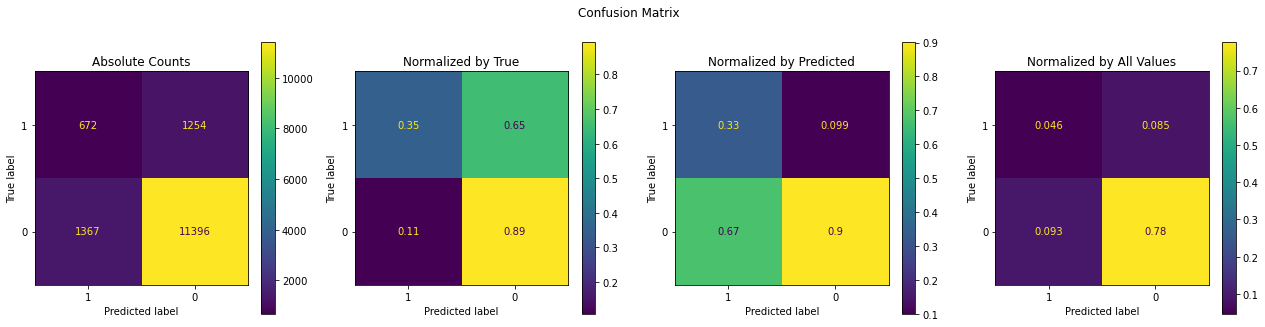

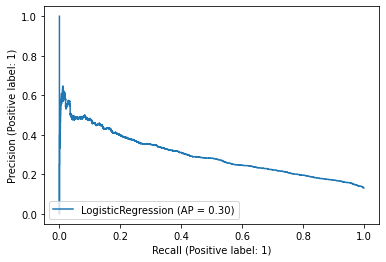

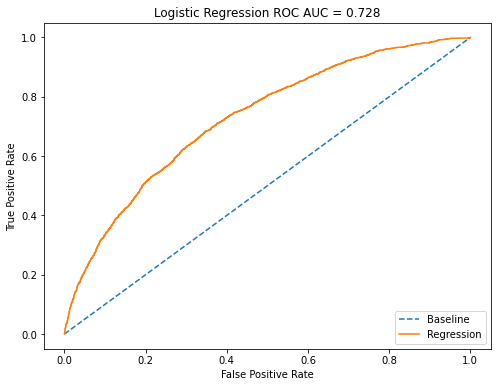

In [115]:
figure, axes = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches((22, 5))
figure.suptitle("Confusion Matrix")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize=None, ax=axes[0])
disp.ax_.set_title("Absolute Counts")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='true', ax=axes[1])
disp.ax_.set_title("Normalized by True")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='pred', ax=axes[2])
disp.ax_.set_title("Normalized by Predicted")
disp = plot_confusion_matrix(fitted_model, X_validation_model, Y_validation_model,
    labels=[1, 0], normalize='all', ax=axes[3])
disp.ax_.set_title("Normalized by All Values")
plt.show()
# ==========
plot_precision_recall_curve(fitted_model, X_validation_model, Y_validation_model)
# ==========
fpr, tpr, threshold = roc_curve(Y_validation_model, Y_validation_predicted_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_score_value)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Выводы

После обучение на тренировочной выборке с применением `SVMSMOTE` **oversamplig**<br />
результаты оптимизации гиперпараметров следующие.

*По сравнению с базовой моделью 3 без подбора гиперпараметров.*<br />
Метрика `accuracy` уменьшилась с `0.87` до `0.82`.
Хотя  метрика `precision` и уменьшилась c `0.54` до `0.33`, но при этом<br />
значительно учучшилась метрика полноты `recall` с `0.027` до `0.35` и<br/>
метрика F1-score - также с `0.051` до ~`0.34`.

*По сравнению с моделью 3 c подбором гиперпараметров без oversampling.*<br />
Метрика `accuracy` увеличилась с `0.67` до `0.82`.
Метрика `precision` увеличилась с `0.24` до `0.33`.
Метрика `recall` упала c `0.67` до `0.34`.<br/>
Метрика F1-score осталась примерно такой же - ~`0.34`.

Модель примерно в равной степени неверно предсказывает<br />
как ложные дефолты, так и ложные возвраты кредитов.
Это приводит к тому, что банк примерно сохраняет столько условных денег,
отказывая по кредитам, сколько и теряет их при выдаче невозвратных кредитов.
*Но*, по сравнению с моделью без oversampling, при проверке модели на валидационной выборке значительно увеличилось число<br /> верно предсказанных выданных и возвращённых кредитов (TN),
что принесёт банку больше денег от большего числа верно распознанных платёжеспособных клиентов.

In [116]:
credit_scoring_with_oversampling_and_hyperpars = fitted_model
submission_model = credit_scoring_with_oversampling_and_hyperpars

## Submission

DataFrame с тестовыми данными был заранее сформирован в объекте `X_test`.<br />
Это было сделано в секции ноутбука "Новое формирование обучающей выборки и тестовой выборки",<br />
где после всех анализов и предобработок было сделано разделение всего объёма данных на<br />
тренировочную, валидационную и тестовую выборки.

Тестовая выборка была снова выделена по критерию столбца `sample == 1`.<br />
После этого столбец `sample` был удалён.<br />
Признаки были стандартизированы.

In [117]:
X_test.sample(5)

client_id  score_bki  decline_app_cnt  bki_request_cnt    income  \
90728      86914   0.394455        -0.342008         0.335772  0.940459   
96196     105174  -1.413299        -0.342008        -1.336180 -1.943701   
75741       2889  -1.737046        -0.342008        -0.281296  0.679481   
90843      60620  -0.050168        -0.342008         1.113186  0.528666   
83808      43995  -0.552422        -0.342008         0.335772 -1.624290   

            age  region_rating  sna  first_time  education   app_date  \
90728  0.061998              4    3           2          2 2014-04-03   
96196  1.189468              7    1           4          2 2014-04-23   
75741  0.669098              5    1           2          5 2014-01-09   
90843  2.316938              4    1           3          4 2014-03-10   
83808 -0.111458              3    1           2          3 2014-02-20   

       day_of_year  good_work  car  car_type  transport_type  \
90728           93          0    1         0               2   
96196          113          0    1         0               2   
75741            9          1    1         1               3   
90843           69          0    0         0               1   
83808           51          1    0         0               1   

       foreign_passport  sex_male  home_address_1  home_address_2  \
90728                 0         1             0.0             1.0   
96196                 0         0             0.0             1.0   
75741                 0         0             1.0             0.0   
90843                 0         0             1.0             0.0   
83808                 0         1             0.0             1.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
90728             0.0             0.0             0.0             1.0  
96196             0.0             0.0             0.0             1.0  
75741             0.0             1.0             0.0             0.0  
90843             0.0             0.0             1.0             0.0  
83808             0.0             0.0             0.0             1.0

Поскольку было выбрано использование Модели 3 со всеми ординальными переменными как номинативными, а не числовыми, то соотвветствующие признаки нужно создать и в тестовой выборке тем же способом (с помощью такого же программного кода).

In [129]:
X_test_model = X_test.copy()
for ordinal_column in ordinal_columns + ["transport_type"]:
    dummies = pd.get_dummies(X_test_model[ordinal_column], prefix=ordinal_column)
    X_test_model = pd.concat([X_test_model, dummies], axis=1)
    X_test_model.drop([ordinal_column], axis=1, inplace=True)

# ========================================
model_variables_X = X_test_model.columns
model_variables_X = list(filter(
    lambda var: ("work_address" not in var) \
        and (var not in ["income"]),
    model_variables_X
))
print(f"model_variables_X[{len(model_variables_X)}]: {model_variables_X}")
# ========================================
X_test_model = X_test_model[model_variables_X]
Y_test_model = Y_training

X_test_model.drop(["client_id", "app_date", "car", "car_type"], axis=1, inplace=True)

X_test_model.sample(3)

model_variables_X[39]: ['client_id', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'age', 'app_date', 'day_of_year', 'good_work', 'car', 'car_type', 'foreign_passport', 'sex_male', 'home_address_1', 'home_address_2', 'home_address_3', 'region_rating_1', 'region_rating_2', 'region_rating_3', 'region_rating_4', 'region_rating_5', 'region_rating_6', 'region_rating_7', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4', 'education_1', 'education_2', 'education_3', 'education_4', 'education_5', 'education_6', 'transport_type_1', 'transport_type_2', 'transport_type_3']


score_bki  decline_app_cnt  bki_request_cnt       age  day_of_year  \
75637   -0.760754        -0.342008        -1.336180  0.495641           14   
104367   1.475832        -0.342008         0.773589  0.148727          104   
104250  -0.304402         0.906687         1.113186 -1.065472           88   

        good_work  foreign_passport  sex_male  home_address_1  home_address_2  \
75637           1                 0         0             0.0             1.0   
104367          0                 0         0             0.0             1.0   
104250          0                 0         0             1.0             0.0   

        home_address_3  region_rating_1  region_rating_2  region_rating_3  \
75637              0.0                0                0                1   
104367             0.0                0                0                0   
104250             0.0                0                0                0   

        region_rating_4  region_rating_5  region_rating_6  region_rating_7  \
75637                 0                0                0                0   
104367                1                0                0                0   
104250                0                1                0                0   

        sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  first_time_3  \
75637       0      0      0      1             1             0             0   
104367      1      0      0      0             1             0             0   
104250      0      1      0      0             0             0             1   

        first_time_4  education_1  education_2  education_3  education_4  \
75637              0            0            1            0            0   
104367             0            0            0            1            0   
104250             0            0            0            1            0   

        education_5  education_6  transport_type_1  transport_type_2  \
75637             0            0                 1                 0   
104367            0            0                 1                 0   
104250            0            0                 1                 0   

        transport_type_3  
75637                  0  
104367                 0  
104250                 0

На всякий случай сравним колонки с валидационными данными.

In [130]:
X_validation_model.sample(3)

score_bki  decline_app_cnt  bki_request_cnt       age  day_of_year  \
4604    0.615222         3.404078         2.007724 -0.111458          104   
8610    0.573316        -0.342008        -1.336180  0.061998           28   
63311   0.425132        -0.342008         0.773589 -0.111458           28   

       good_work  foreign_passport  sex_male  home_address_1  home_address_2  \
4604           0                 0         0             0.0             1.0   
8610           0                 1         1             0.0             1.0   
63311          0                 0         0             1.0             0.0   

       home_address_3  region_rating_1  region_rating_2  region_rating_3  \
4604              0.0                0                0                0   
8610              0.0                0                0                0   
63311             0.0                0                0                0   

       region_rating_4  region_rating_5  region_rating_6  region_rating_7  \
4604                 0                1                0                0   
8610                 1                0                0                0   
63311                1                0                0                0   

       sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  first_time_3  \
4604       1      0      0      0             0             0             1   
8610       0      1      0      0             1             0             0   
63311      0      1      0      0             0             0             1   

       first_time_4  education_1  education_2  education_3  education_4  \
4604              0            0            1            0            0   
8610              0            0            1            0            0   
63311             0            0            1            0            0   

       education_5  education_6  transport_type_1  transport_type_2  \
4604             0            0                 1                 0   
8610             0            0                 1                 0   
63311            0            0                 1                 0   

       transport_type_3  
4604                  0  
8610                  0  
63311                 0

In [131]:
predict_submission = submission_model.predict_proba(X_test_model)[:,1]

In [134]:
submission = pd.DataFrame(X_test.client_id)
submission['default'] = predict_submission
submission.to_csv('../00-data/kaggle/submission.csv', index=False)

## Возможные направления по улучшению модели

Необходим дальнейший анализ влияния различных значений ординальных и номинативных переменных.

В случае с ординальными переменными может быть стоит варьировать расстояния между отдельными значениями ординальных переменных, тем самым меняя их шкалы. Это позволило бы уменьшить размерность задачи и не использовать большое количество dummy переменных.

В случае с номинативными переменными нужно больше информации о том, что означает каждая категория
адреса работы и домашнего адреса, что позволило бы также подобрать в будущем иные веса для этих признаков, преобразовав их в один или два новых признака, хранящих рейтинги домашнего и рабочего адресов. Это также позволило бы избавиться от признаков адресов частично или полностью и тем самым убрать лишние корреляции.

Необходимо проверить чем можно заменить признаки `sna` и `first_time`. Какой один признак может заменить их оба, поскольку между `sna` и `first_time` есть высокая корреляция, но удаление одного из этих признаков немного ухудшает результаты обучения. Возможно здесь поможет перемножение этих признаков или создание иных полиномиальных признаков, отражающих давность вовлечённости клиента в сообщество клиентов банка.

Необходимо изучить другие возможности, другие алгоритмы по устранению несбалансированности выборки для кредитного скоринга и по варьированию их гиперпараметров.
Но это потребует значительных затрат дополнительного машинного времени.

Нужно провести более широкое варьирование гиперпараметров для модели логистической регрессии совместно с варьированием гиперпараметров для алгоритмов Oversampling.
Это требует отдельного исследования с большими вычислительными затратами.